In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky

from scipy.sparse.linalg import onenormest, splu, LinearOperator

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def condest(A):
    luA = splu(A)
    iA = LinearOperator(luA.shape, matvec = lambda x : luA.solve(x), rmatvec = lambda x : luA.solve(x))
    return onenormest(iA)*onenormest(A)

In [3]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [4]:
def Inductor(deg,N):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,0.025)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.275)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.775)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.025)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.025)),
        geometry.unit_square().scale(0.5).translate((1.5,1.025)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [5]:
mu0 = 4*pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}

In [6]:
def uniform(deg, maxiter=5):
    M = Inductor(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    uh=[]
    numdofs = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True
    Eh=np.zeros(maxiter)
    
    time_mesh = np.zeros(maxiter)
    time_solve = np.zeros(maxiter)
    nnz = np.zeros(maxiter)
    nnzQ = np.zeros(maxiter)
    # nnzL = np.zeros(maxiter)
    # nnzLQ = np.zeros(maxiter)
    Eh = np.zeros(maxiter)
    #cond = np.zeros(maxiter)

    for i in range(maxiter):
        print('----------------------------------------------------')
        print(i)
        bcs = MP.compute_dirichlet_bcs({0:0.})
        Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        Mh = MP.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
        
        nnz[i] = LS.A.nnz
        nnzQ[i] = 100*LS.A.nnz/np.prod(LS.A.shape)
        # if i < 6:
        #     cond[i]=condest(LS.A)
        # solver = scipy.sparse.linalg.splu(LS.A)
        # nnzL[i] = solver.L.nnz
        # nnzLQ[i] = 100*solver.L.nnz/np.prod(solver.L.shape)
        
        t=time.time()
        uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        time_solve[i] = time.time()-t
        numdofs[i] = MP.numdofs
        Eh[i] = 0.0254 * 0.5 * uh[-1]@Ah@uh[-1]
        print('Number of doFs: ' + str(MP.numdofs))
        print('Energy: ' + str(Eh[i]))

        t=time.time()
        if i < maxiter-2:
            P.append(MP.h_refine(h_ref=-1, return_P=return_P))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=return_P))
        else:
            pass
        time_mesh[i]=time.time()-t

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err = np.zeros(maxiter)
    H1err = np.zeros(maxiter)
    Aherr = np.zeros(maxiter)
    Eherr = np.zeros(maxiter)
    for i in range(len(uh)-1):
        eh = P[i]@uh[i]-uh[-1]
        L2err[i] = eh @ Mh @ eh
        H1err[i] = eh @ Kh @ eh + L2err[i]
        Aherr[i] = eh @ Ah @ eh

    L2err = sqrt(L2err)
    H1err = sqrt(H1err)
    Aherr = sqrt(Aherr)
    
    return MP, numdofs, uh, nnz, nnzQ, L2err, H1err, Aherr, Eh, time_mesh, time_solve

In [13]:
def geometric(deg, maxiter=15, returnP =True):
    M = Inductor(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    uh=[]
    numdofs = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True
    
    time_mesh = np.zeros(maxiter)
    time_solve = np.zeros(maxiter)
    nnz = np.zeros(maxiter)
    nnzQ = np.zeros(maxiter)
    #nnzL = np.zeros(maxiter)
    #nnzLQ = np.zeros(maxiter)
    Eh = np.zeros(maxiter)
    cond = np.zeros(maxiter)

    for i in range(maxiter):
        print('----------------------------------------------------')
        print(i)
        MP.mesh.draw(color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'},knots=True)
        plt.axis('off');
        plt.axis('scaled');
        plt.savefig('/home/wolfman/Pictures/Inductor/geom_mesh/i'+str(i)+'.png',bbox_inches='tight');
        plt.show()
        
        bcs = MP.compute_dirichlet_bcs({0:0.})
        Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        Mh = MP.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
        
        nnz[i] = LS.A.nnz
        nnzQ[i] = 100*LS.A.nnz/np.prod(LS.A.shape)
        # if i < 5:
        #     cond[i]=condest(LS.A)
        # solver = scipy.sparse.linalg.splu(LS.A)
        # nnzL[i] = solver.L.nnz
        # nnzLQ[i] = 100*solver.L.nnz/np.prod(solver.L.shape)
        
        t=time.time()
        uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        time_solve[i]=time.time()-t
        
        numdofs[i] = MP.numdofs
        Eh[i] = 0.0254 * 0.5 * uh[-1]@Ah@uh[-1]
        #Eh[i] = MP.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_ =uh[-1], nu=nu)*0.0254
        print('Number of doFs: ' + str(MP.numdofs))
        print('Energy: ' + str(Eh[i]))

        t = time.time()
        if i < maxiter-2:
            if (i+1)%100==0:
                P.append(MP.h_refine(h_ref=-1, return_P=return_P))
            else:
                P.append(MP.h_refine(h_ref='q', return_P=return_P))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=return_P))
        else:
            pass
        time_mesh[i] = time.time()-t

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err = np.zeros(maxiter)
    H1err = np.zeros(maxiter)
    Aherr = np.zeros(maxiter)
    Eherr = np.zeros(maxiter)
    
    if returnP:
        for i in range(len(uh)-1):
            eh = P[i]@uh[i]-uh[-1]
            L2err[i] = eh @ Mh @ eh
            H1err[i] = eh @ Kh @ eh + L2err[i]
            Aherr[i] = eh @ Ah @ eh

        L2err = sqrt(L2err)
        H1err = sqrt(H1err)
        Aherr = sqrt(Aherr)
    
    return MP, numdofs, uh, nnz, nnzQ, L2err, H1err, Aherr, Eh, time_mesh, time_solve

In [30]:
M = Inductor(2,3)
MP = assemble.Multipatch(M, automatch=True)

Basis setup took 0.013529777526855469 seconds


In [15]:
for deg, maxiter in zip((2,),(20,)):
    MP, numdofs, uh, nnz, nnzQ, L2err, H1err, Aherr, Eh, time_mesh, time_solve = uniform(deg,maxiter)
    np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs, nnz, nnzQ, H1err,L2err,Aherr,Eh,time_mesh,time_solve]])

Basis setup took 0.012796163558959961 seconds
----------------------------------------------------
0
Number of doFs: 725
Energy: 0.0008654770655053184
Refinement took 0.0014262199401855469 seconds for 42 patches.
Basis setup took 0.014603614807128906 seconds
Prolongation took 0.07356715202331543 seconds
----------------------------------------------------
1
Number of doFs: 2150
Energy: 0.0008763649541303452
Refinement took 0.0014693737030029297 seconds for 42 patches.
Basis setup took 0.019646406173706055 seconds
Prolongation took 0.08176279067993164 seconds
----------------------------------------------------
2
Number of doFs: 7268
Energy: 0.0008815644860982698
Refinement took 0.0016400814056396484 seconds for 42 patches.
Basis setup took 0.03255200386047363 seconds
Prolongation took 0.08405208587646484 seconds
----------------------------------------------------
3
Number of doFs: 26576
Energy: 0.0008836790055448084
Refinement took 0.0016796588897705078 seconds for 42 patches.
Basis s

----------------------------------------------------
0


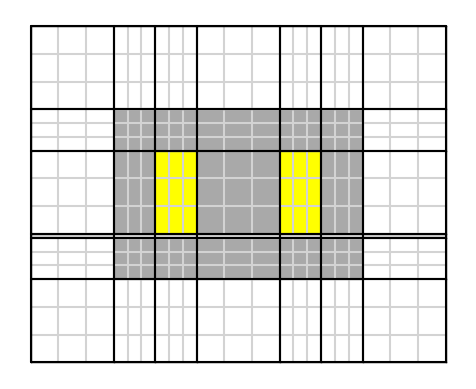

Number of doFs: 725
Energy: 0.0008654770655053184
----------------------------------------------------
1


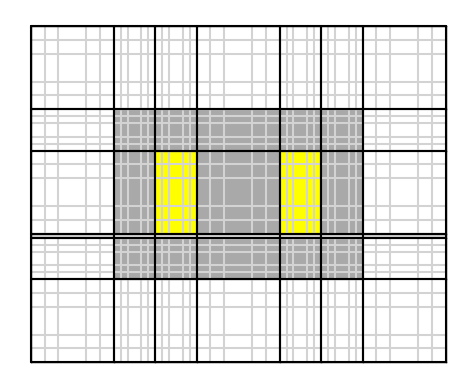

Number of doFs: 1591
Energy: 0.0008762279391227163
----------------------------------------------------
2


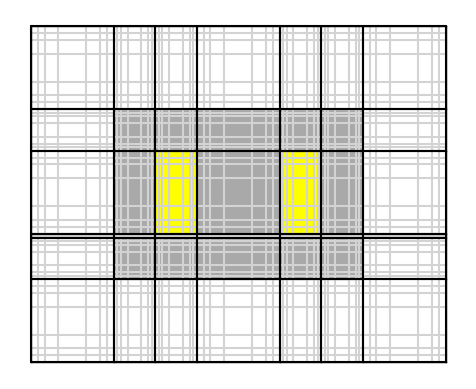

Number of doFs: 2793
Energy: 0.0008814870706336266
----------------------------------------------------
3


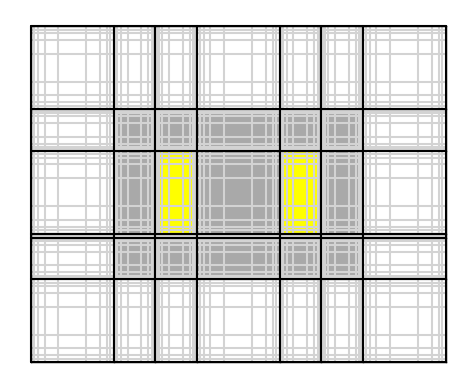

Number of doFs: 4331
Energy: 0.0008836320561499031
----------------------------------------------------
4


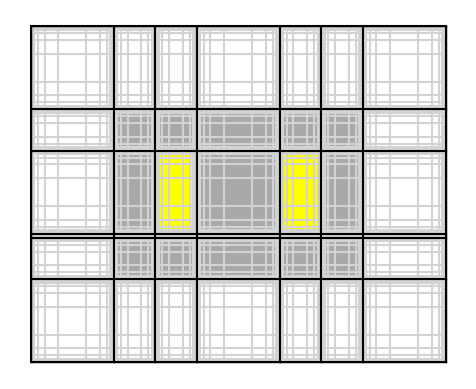

Number of doFs: 6205
Energy: 0.000884447929125483
----------------------------------------------------
5


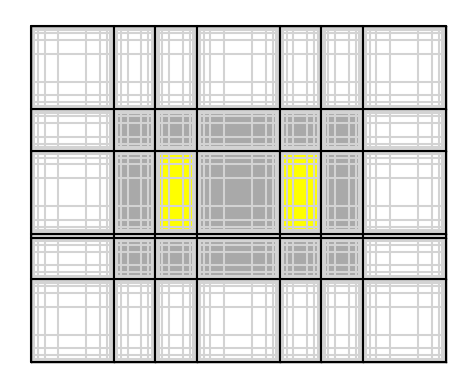

Number of doFs: 8415
Energy: 0.0008847654855540684
----------------------------------------------------
6


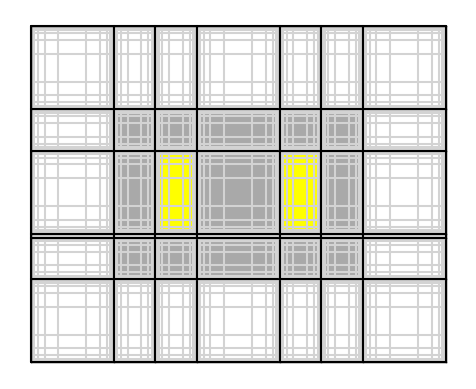

Number of doFs: 10961
Energy: 0.0008848902590289882
----------------------------------------------------
7


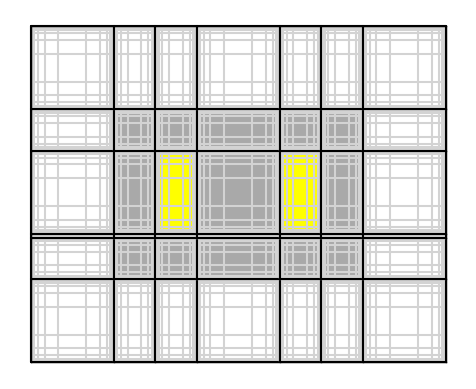

Number of doFs: 13843
Energy: 0.0008849394697204102
----------------------------------------------------
8


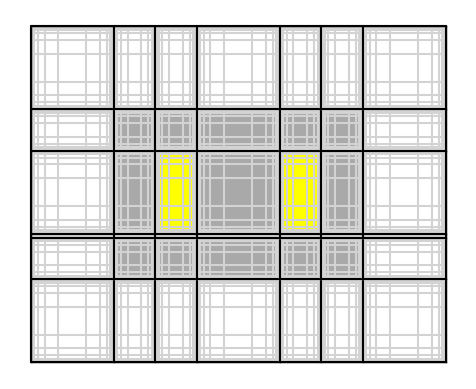

Number of doFs: 17061
Energy: 0.0008849589218359069
----------------------------------------------------
9


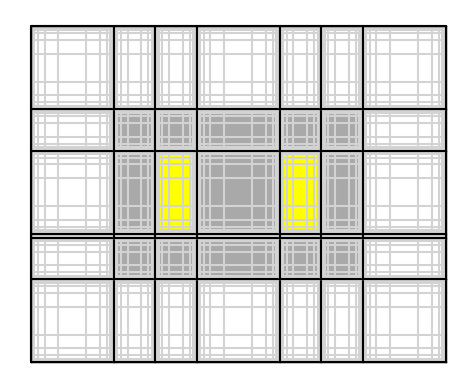

Number of doFs: 20615
Energy: 0.0008849666213989328
----------------------------------------------------
10


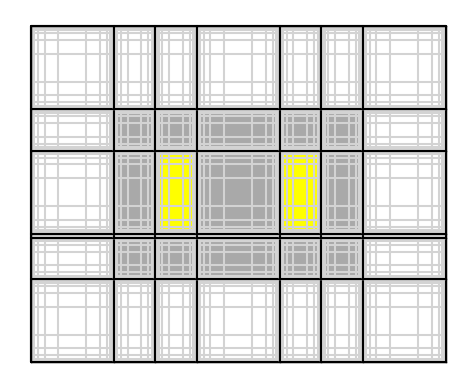

Number of doFs: 24505
Energy: 0.0008849696715013107
----------------------------------------------------
11


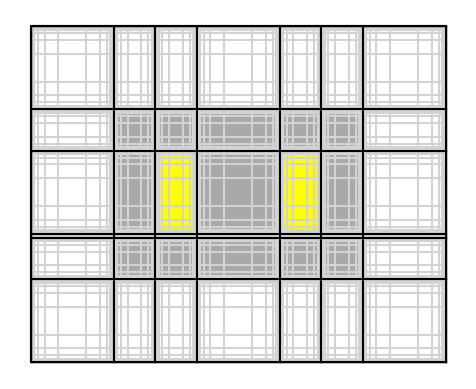

Number of doFs: 28731
Energy: 0.0008849708804196111
----------------------------------------------------
12


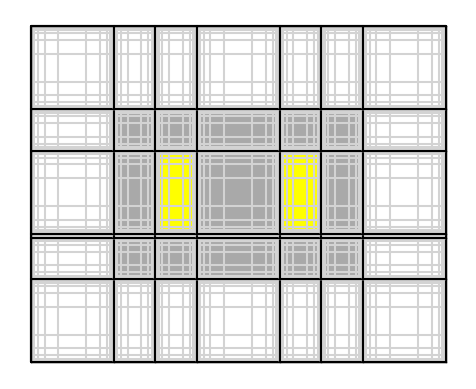

Number of doFs: 33293
Energy: 0.0008849713590719774
----------------------------------------------------
13


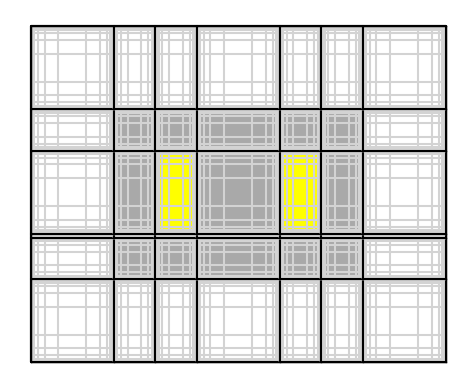

Number of doFs: 38191
Energy: 0.0008849715487373406
----------------------------------------------------
14


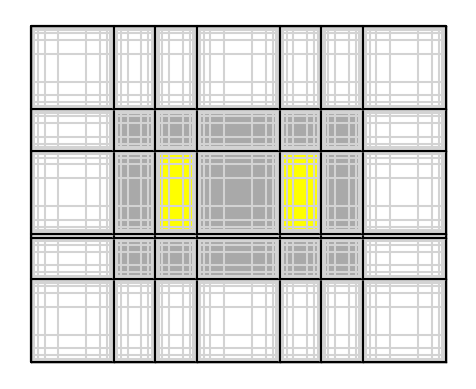

Number of doFs: 43425
Energy: 0.0008849716255188387
----------------------------------------------------
15


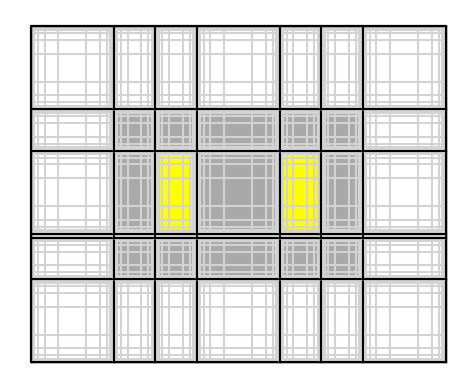

Number of doFs: 48995
Energy: 0.000884971655412479
----------------------------------------------------
16


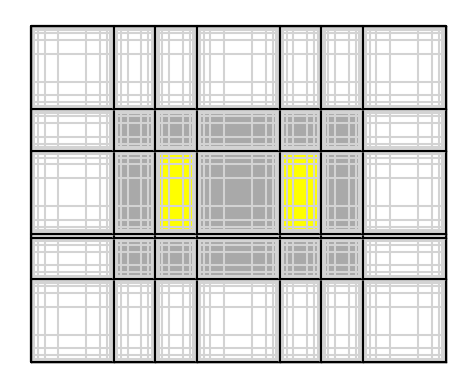

Number of doFs: 54901
Energy: 0.0008849716559761777
----------------------------------------------------
17


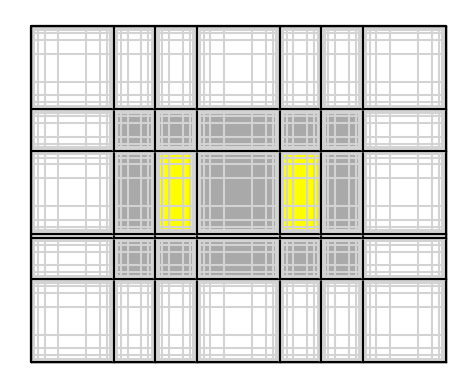

Number of doFs: 61143
Energy: 0.0008849716761524515
----------------------------------------------------
18


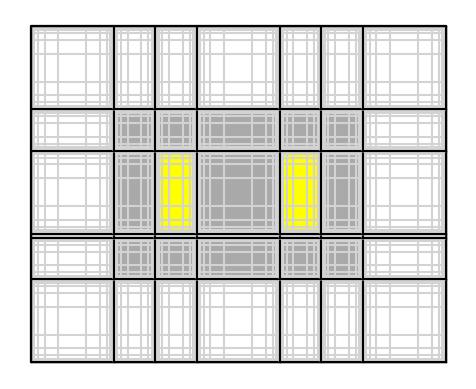

Number of doFs: 67721
Energy: 0.000884971680525744
----------------------------------------------------
19


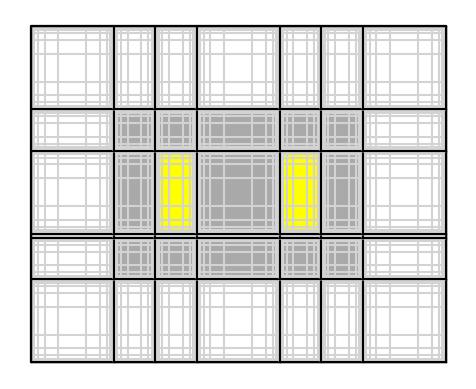

Number of doFs: 263150
Energy: 0.0008849982581734816


In [14]:
for deg, maxiter in zip((2,),(20,)):
    MP_geo, numdofs_geo, uh, nnz_geo, nnzQ_geo, L2err_geo, H1err_geo, Aherr_geo, Eh_geo, time_mesh_geo, time_solve_geo = geometric(deg,maxiter)
    #np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'geo.txt', np.c_[[numdofs_geo, nnz_geo, nnzQ_geo , H1err_geo, L2err_geo, Aherr_geo, Eh_geo, time_mesh_geo, time_solve_geo]])

------------------------------------------------------
0
Number of DoFs: 725
Energy: 0.0008654770655053184 J
Inductance: 1.7309541310106369 mH


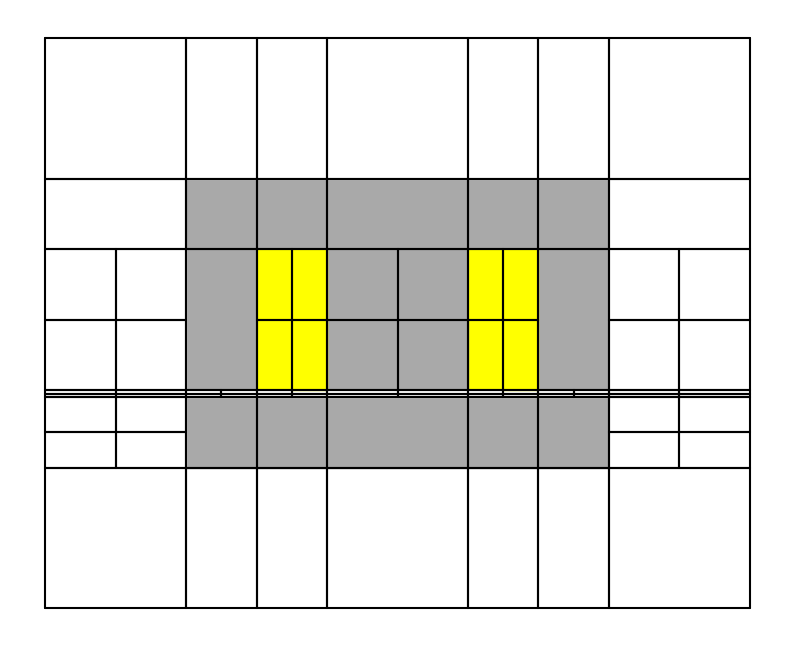

------------------------------------------------------
1
Number of DoFs: 1369
Energy: 0.0008727940680420161 J
Inductance: 1.7455881360840322 mH


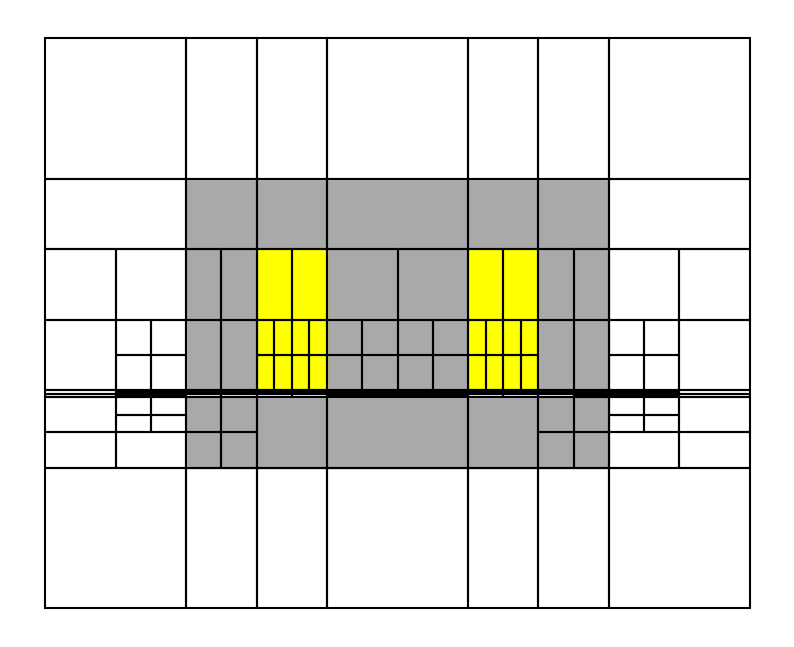

------------------------------------------------------
2
Number of DoFs: 2781
Energy: 0.0008793083159086345 J
Inductance: 1.7586166318172691 mH


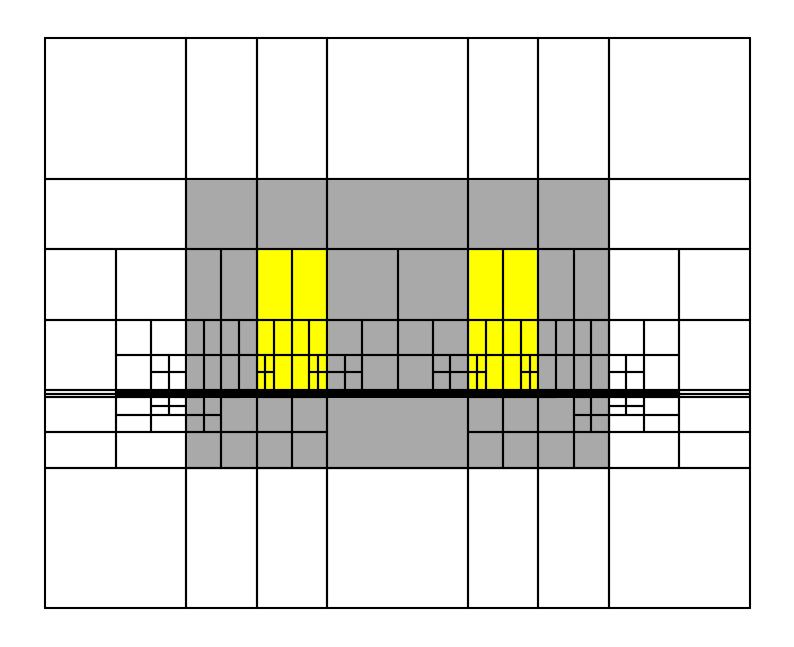

------------------------------------------------------
3
Number of DoFs: 4589
Energy: 0.0008825302778021299 J
Inductance: 1.7650605556042598 mH


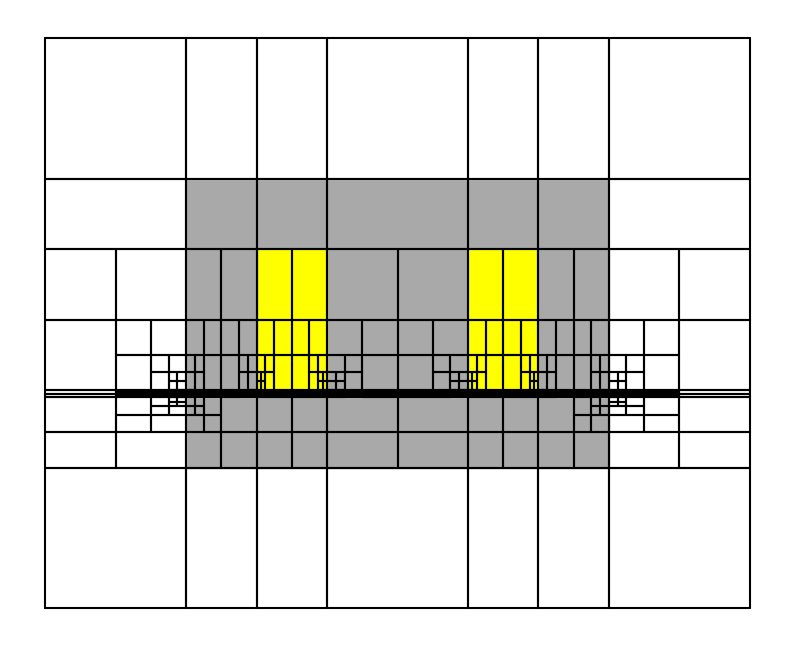

------------------------------------------------------
4
Number of DoFs: 6721
Energy: 0.0008839738591490336 J
Inductance: 1.7679477182980672 mH


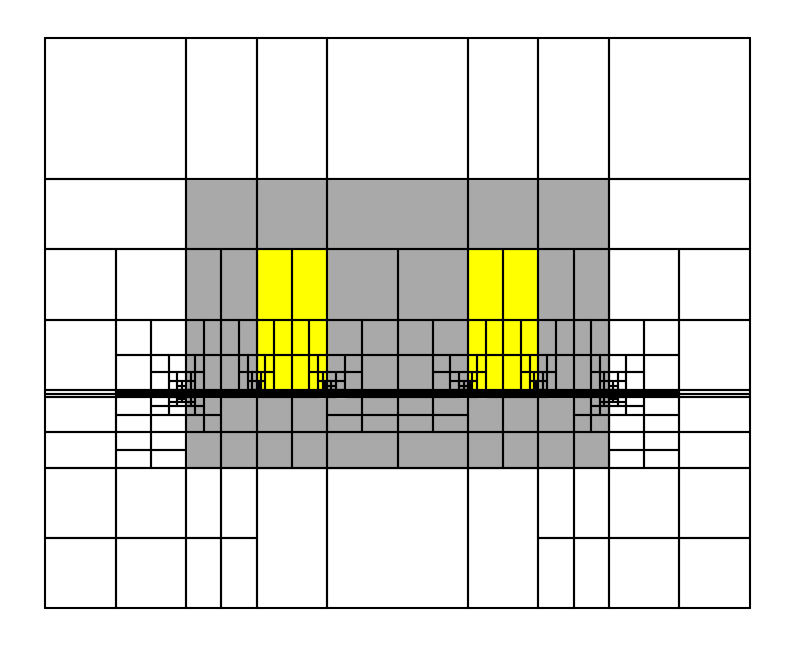

------------------------------------------------------
5
Number of DoFs: 9849
Energy: 0.0008845336517677117 J
Inductance: 1.7690673035354234 mH


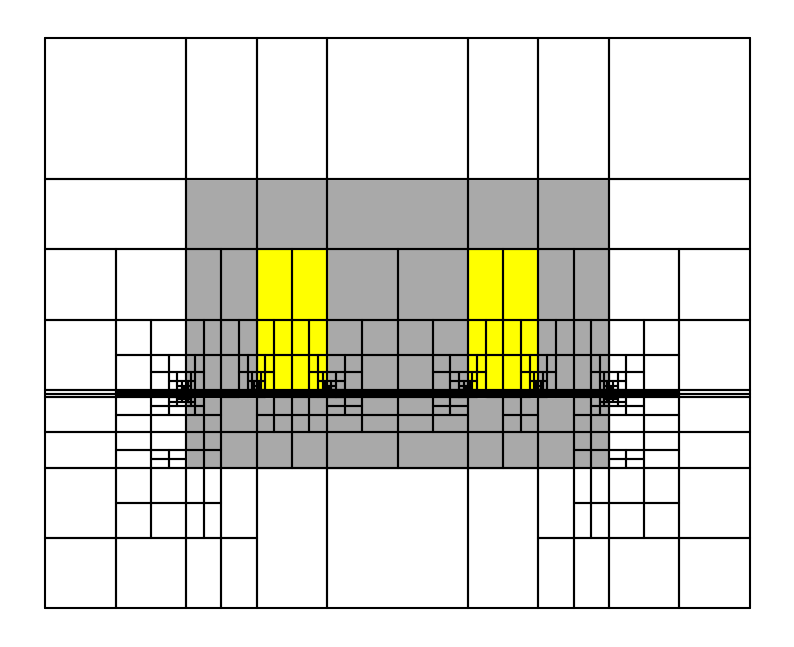

------------------------------------------------------
6
Number of DoFs: 13801
Energy: 0.0008847685856988224 J
Inductance: 1.7695371713976449 mH


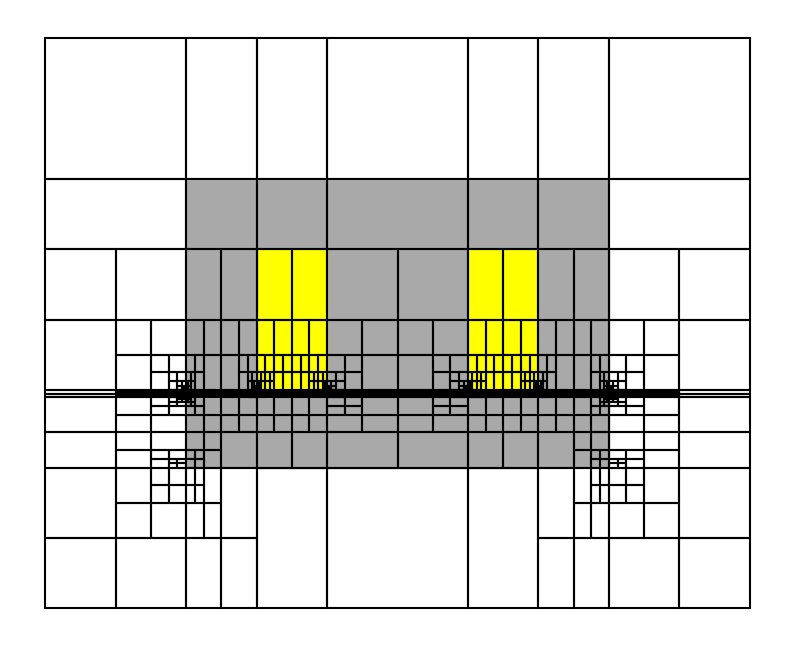

------------------------------------------------------
7
Number of DoFs: 18713
Energy: 0.0008848699590959154 J
Inductance: 1.7697399181918307 mH


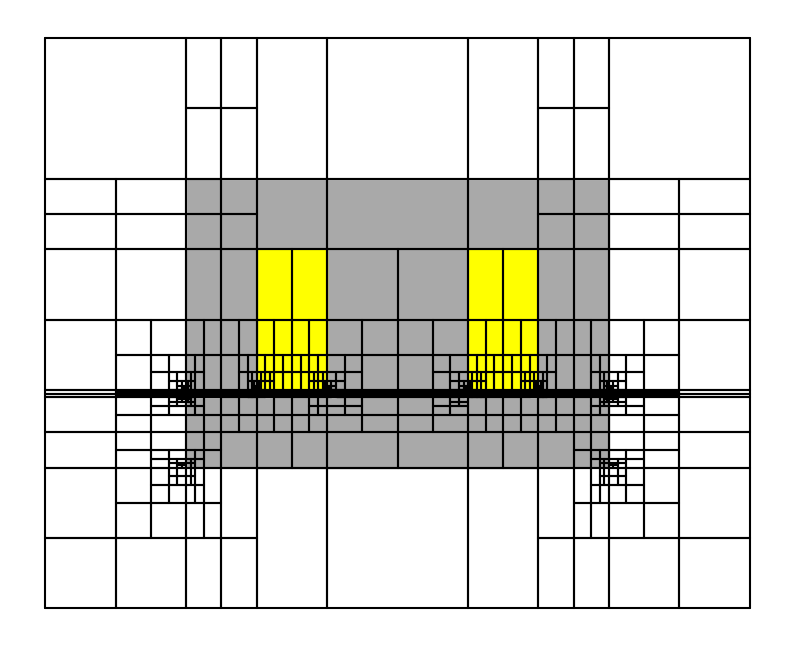

------------------------------------------------------
8
Number of DoFs: 24045
Energy: 0.0008849128132955784 J
Inductance: 1.7698256265911567 mH


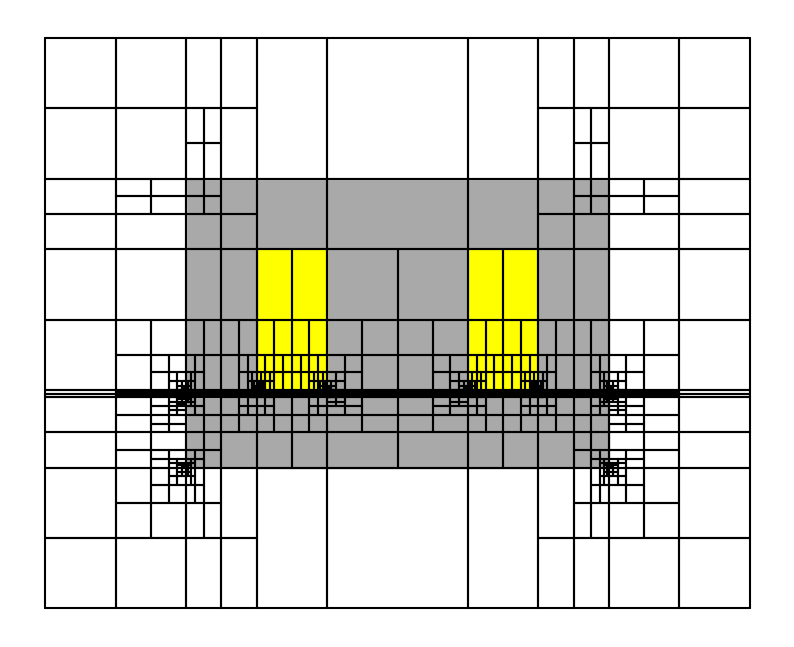

------------------------------------------------------
9
Number of DoFs: 31709
Energy: 0.0008849298859378288 J
Inductance: 1.7698597718756575 mH


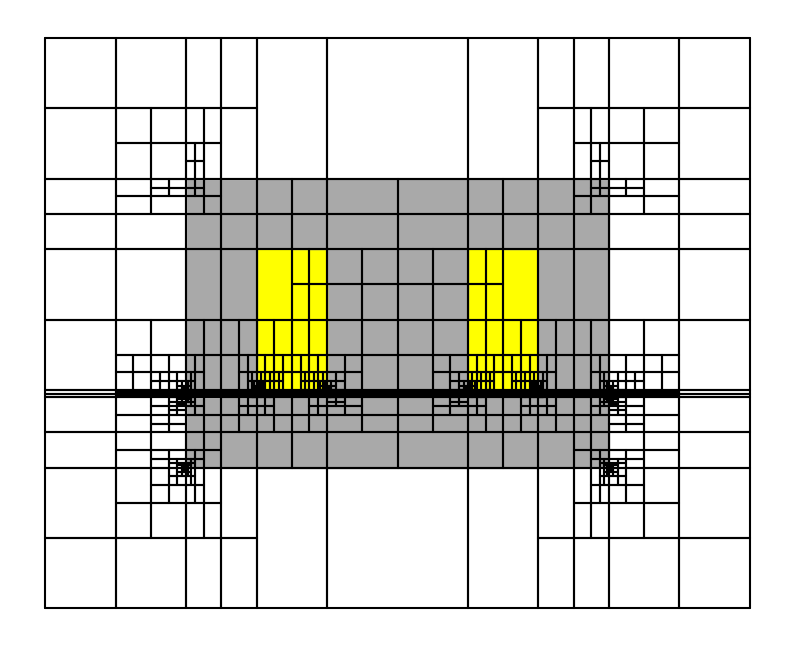

------------------------------------------------------
10
Number of DoFs: 40945
Energy: 0.0008849691750119008 J
Inductance: 1.7699383500238015 mH


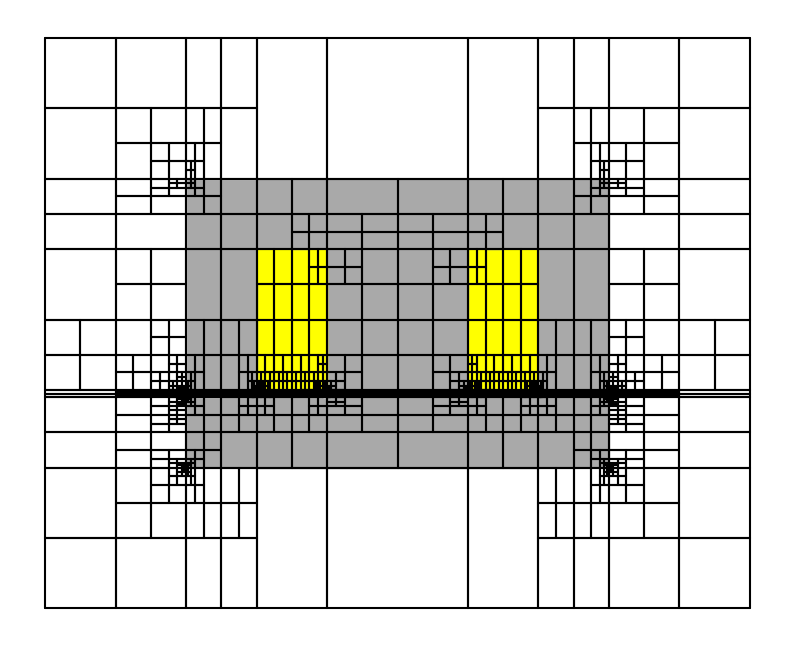

------------------------------------------------------
11
Number of DoFs: 54421
Energy: 0.0008849817410658456 J
Inductance: 1.7699634821316912 mH


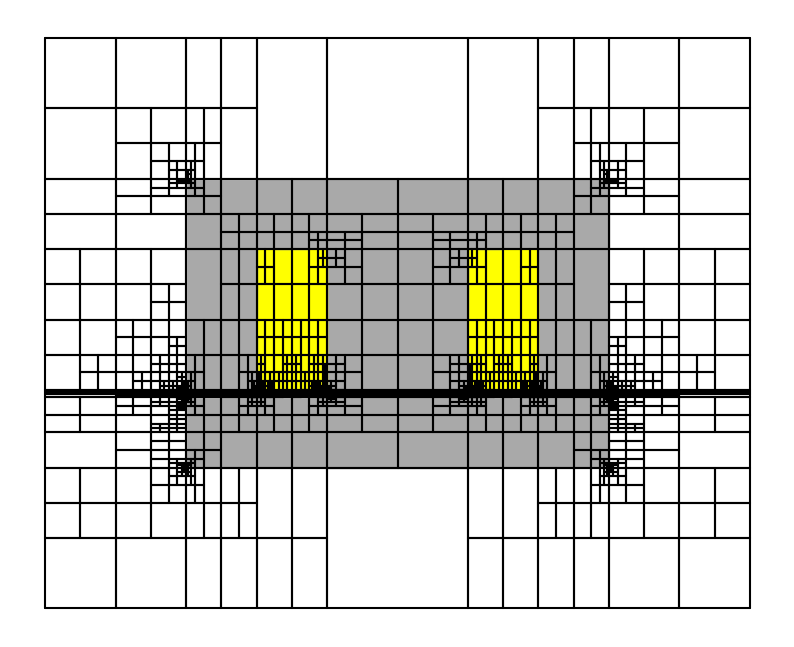

------------------------------------------------------
12
Number of DoFs: 72489
Energy: 0.0008849926801629228 J
Inductance: 1.7699853603258455 mH


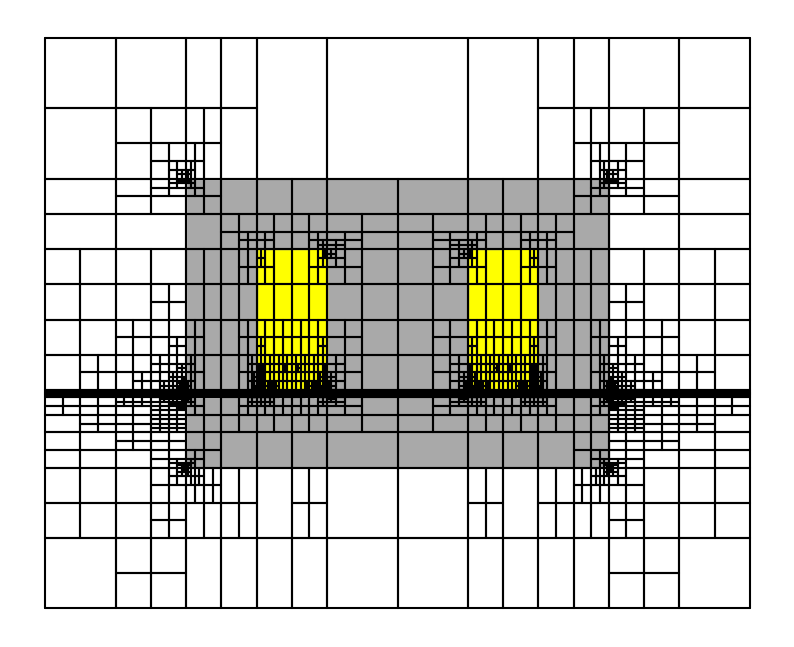

------------------------------------------------------
13
Number of DoFs: 98189
Energy: 0.0008849970675191077 J
Inductance: 1.7699941350382153 mH
------------------------------------------------------
14
Number of DoFs: 309422
Energy: 0.0008849990234039656 J
Inductance: 1.7699980468079313 mH
------------------------------------------------------
0
Number of DoFs: 1591
Energy: 0.0008771873428446199 J
Inductance: 1.7543746856892397 mH


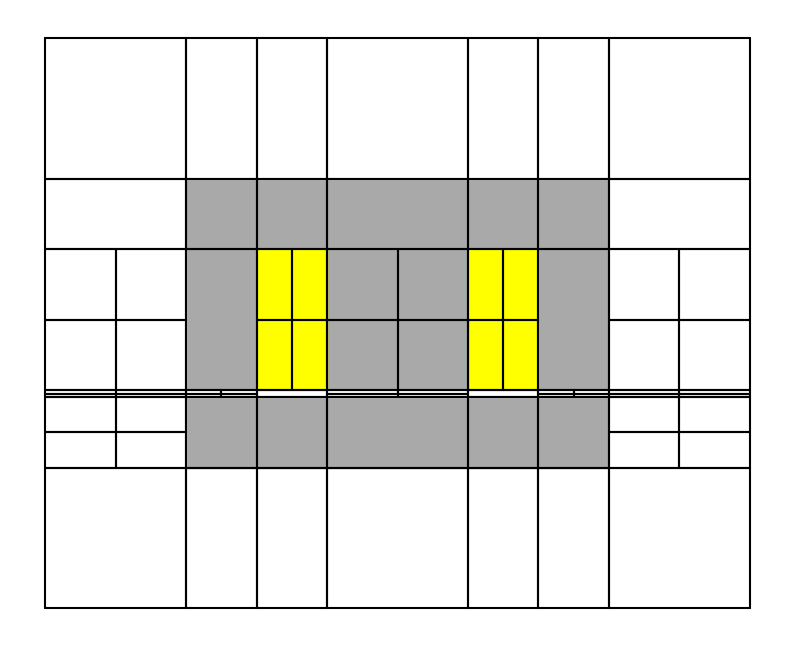

------------------------------------------------------
1
Number of DoFs: 2833
Energy: 0.0008804409587819779 J
Inductance: 1.7608819175639558 mH


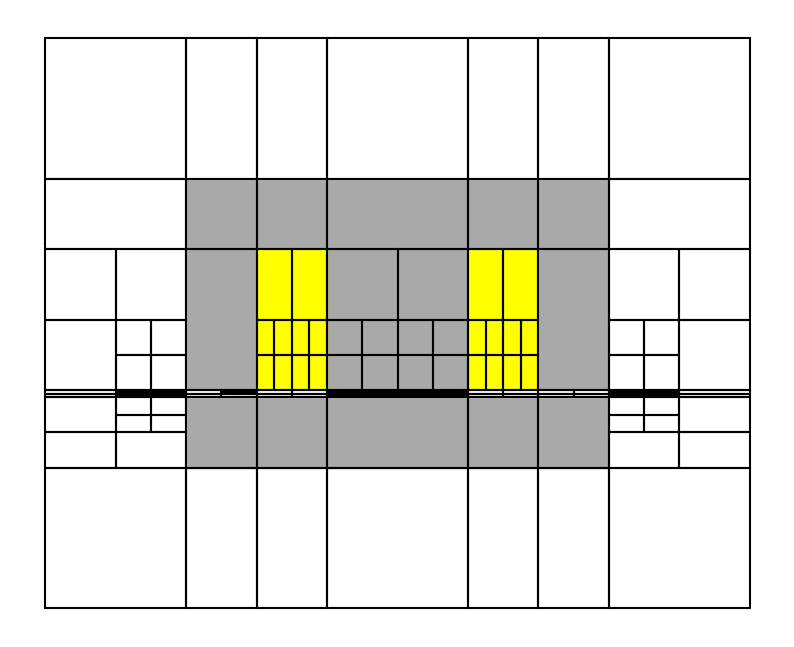

------------------------------------------------------
2
Number of DoFs: 4987
Energy: 0.0008814934070205784 J
Inductance: 1.7629868140411569 mH


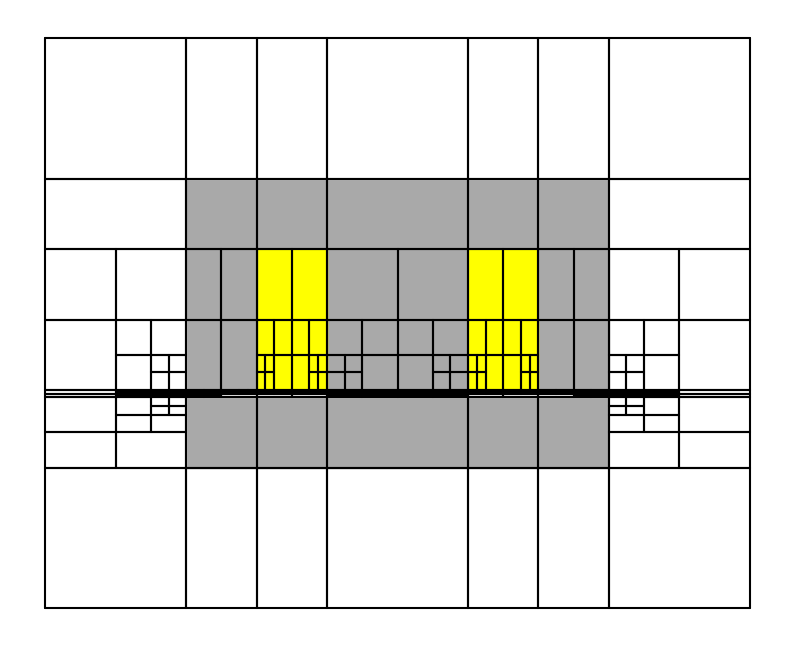

------------------------------------------------------
3
Number of DoFs: 7867
Energy: 0.0008832824010749094 J
Inductance: 1.7665648021498188 mH


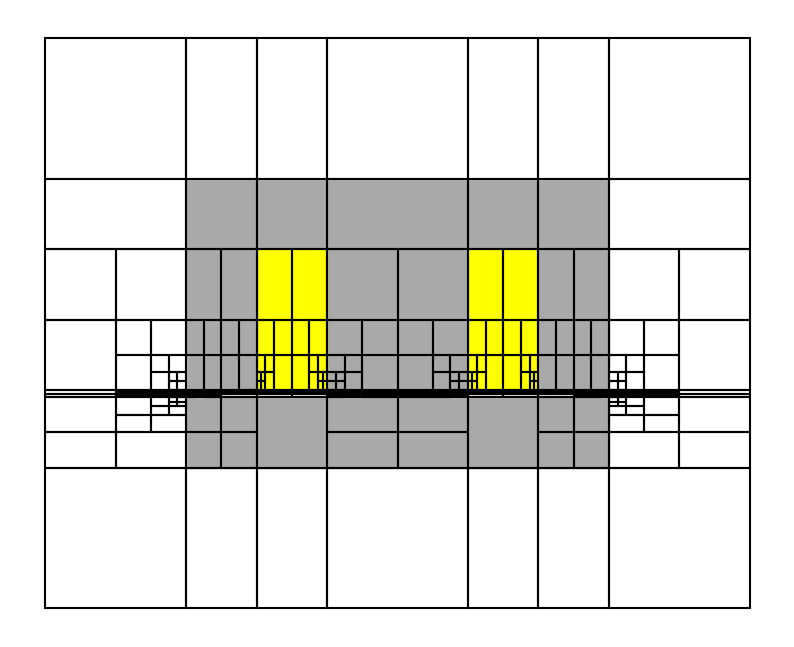

------------------------------------------------------
4
Number of DoFs: 11641
Energy: 0.0008842857768594532 J
Inductance: 1.7685715537189064 mH


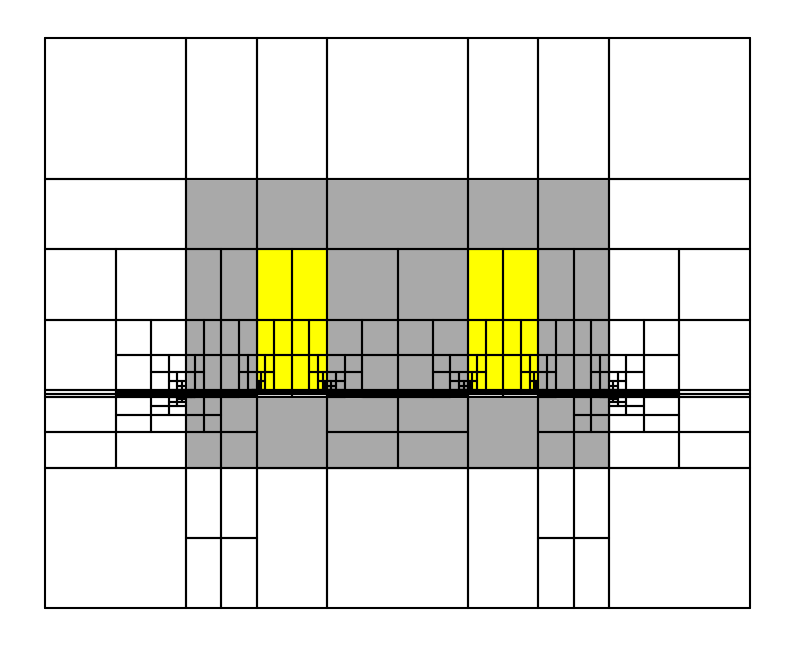

------------------------------------------------------
5
Number of DoFs: 16471
Energy: 0.0008846930920366593 J
Inductance: 1.7693861840733187 mH


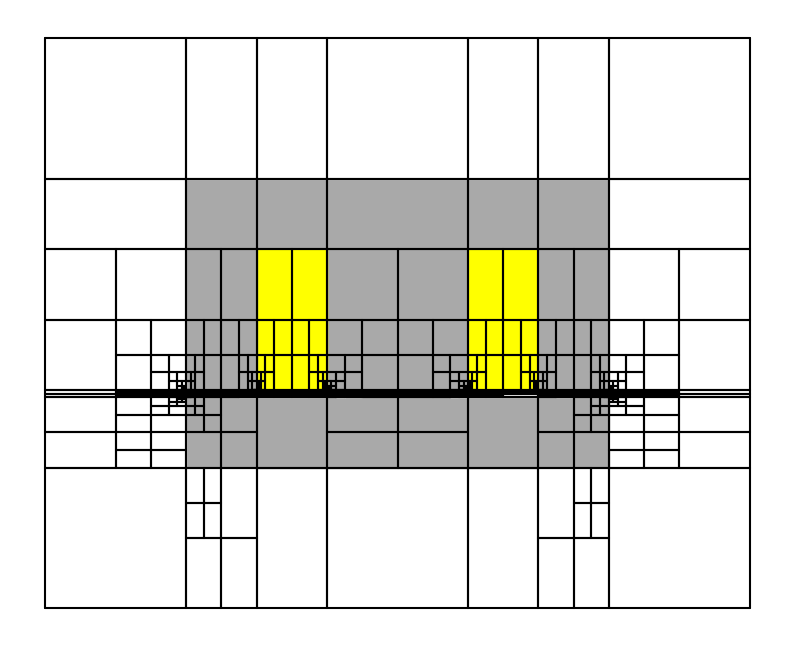

------------------------------------------------------
6
Number of DoFs: 22003
Energy: 0.0008848581688685059 J
Inductance: 1.7697163377370118 mH


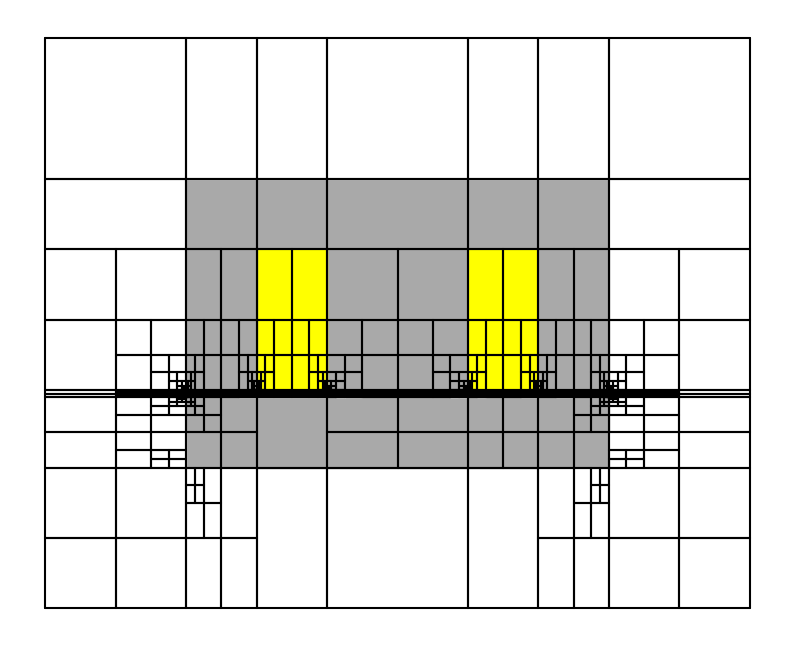

------------------------------------------------------
7
Number of DoFs: 28855
Energy: 0.0008849253836730505 J
Inductance: 1.769850767346101 mH


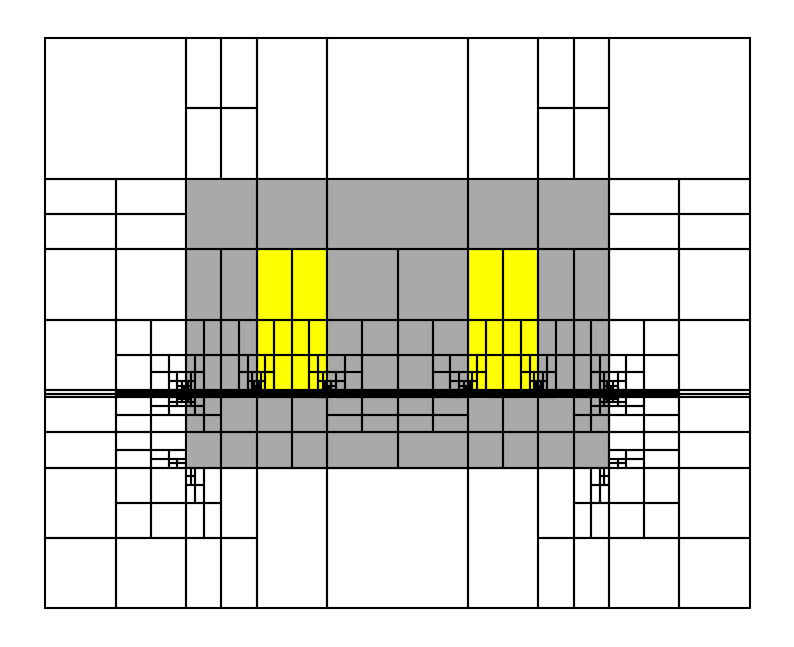

------------------------------------------------------
8
Number of DoFs: 38131
Energy: 0.0008849587509207185 J
Inductance: 1.769917501841437 mH


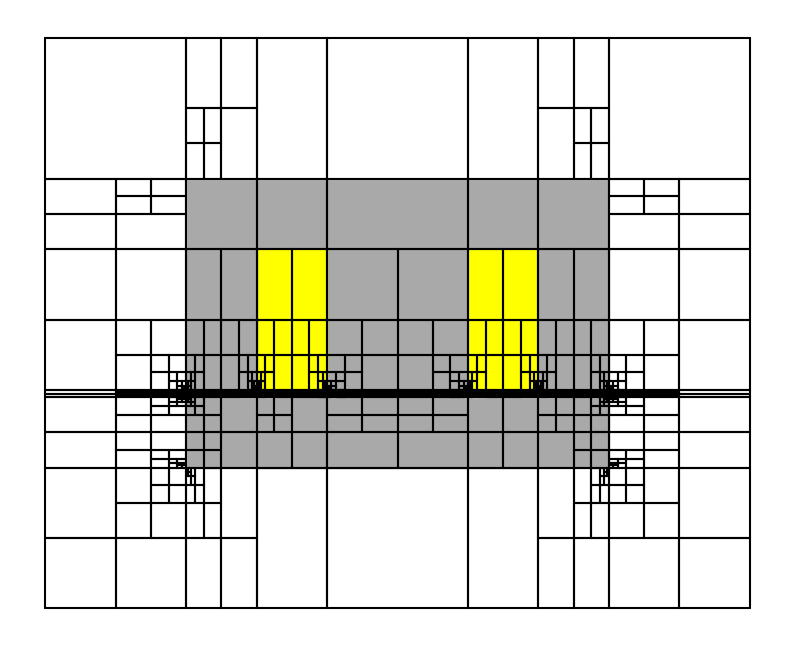

------------------------------------------------------
9
Number of DoFs: 48037
Energy: 0.0008849698885902515 J
Inductance: 1.769939777180503 mH


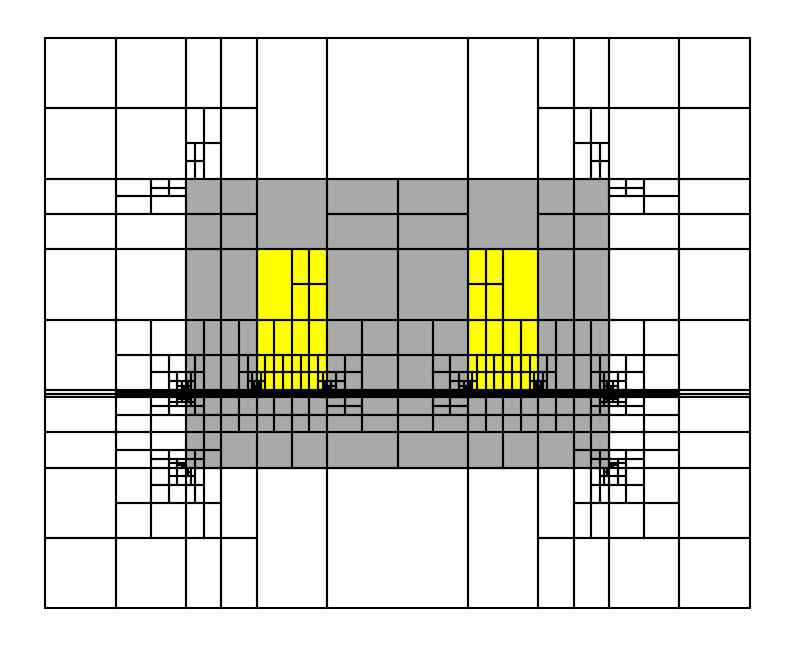

------------------------------------------------------
10
Number of DoFs: 60577
Energy: 0.0008849844923799936 J
Inductance: 1.769968984759987 mH


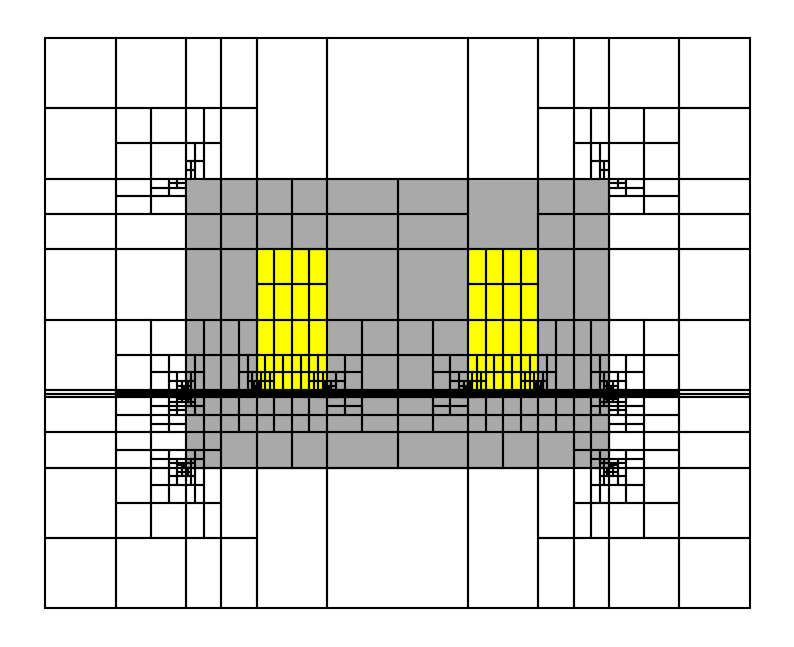

------------------------------------------------------
11
Number of DoFs: 74959
Energy: 0.0008849879665008308 J
Inductance: 1.7699759330016616 mH


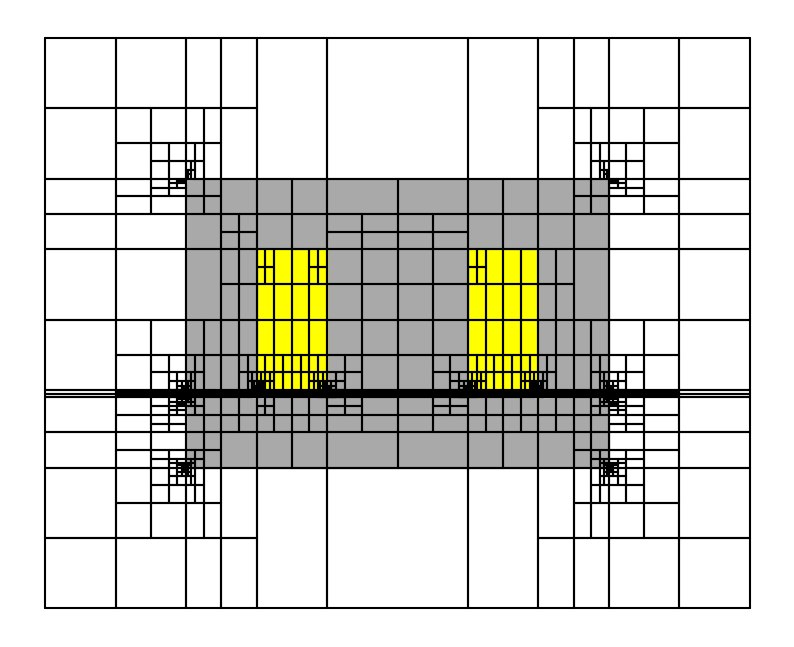

------------------------------------------------------
12
Number of DoFs: 91171
Energy: 0.0008849941494653342 J
Inductance: 1.7699882989306683 mH


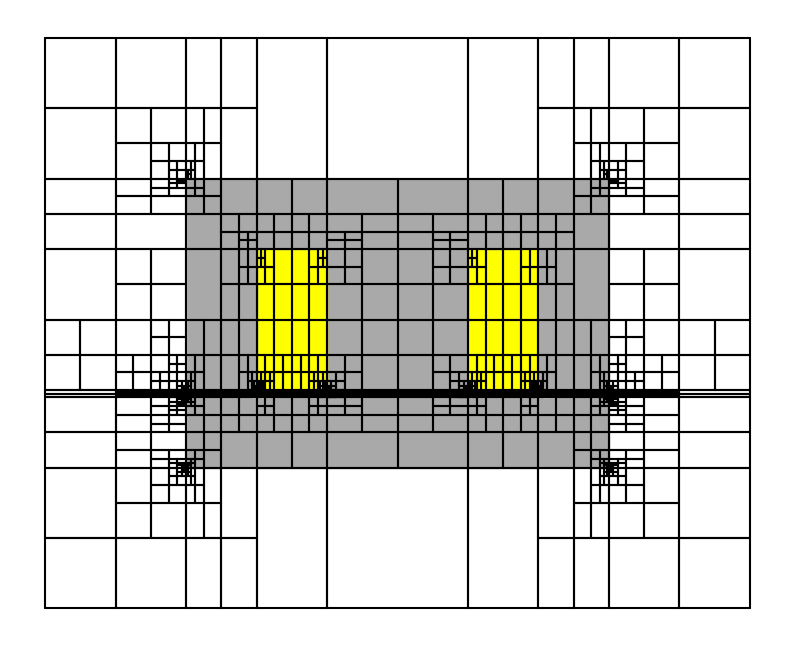

------------------------------------------------------
13
Number of DoFs: 112471
Energy: 0.0008849977008342606 J
Inductance: 1.7699954016685213 mH


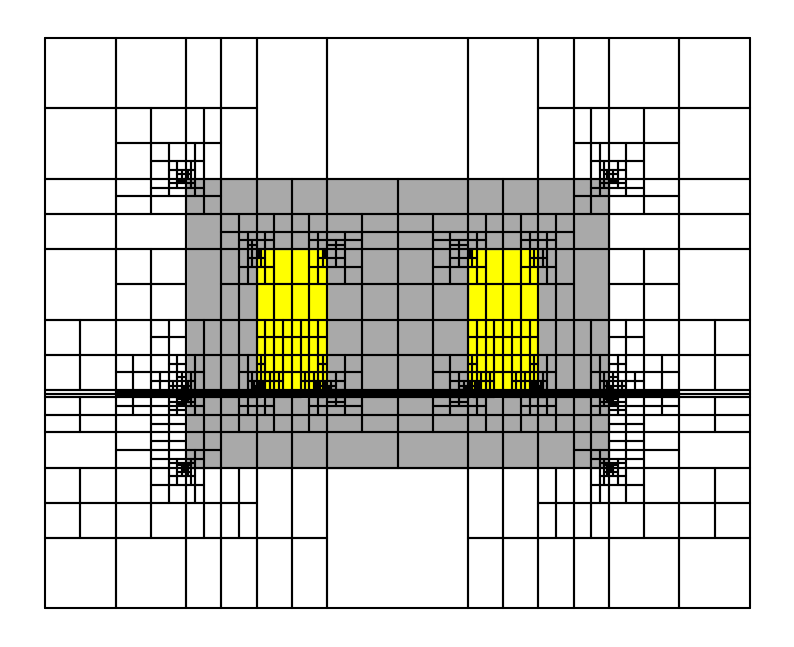

------------------------------------------------------
14
Number of DoFs: 139993
Energy: 0.0008849991100796969 J
Inductance: 1.7699982201593938 mH


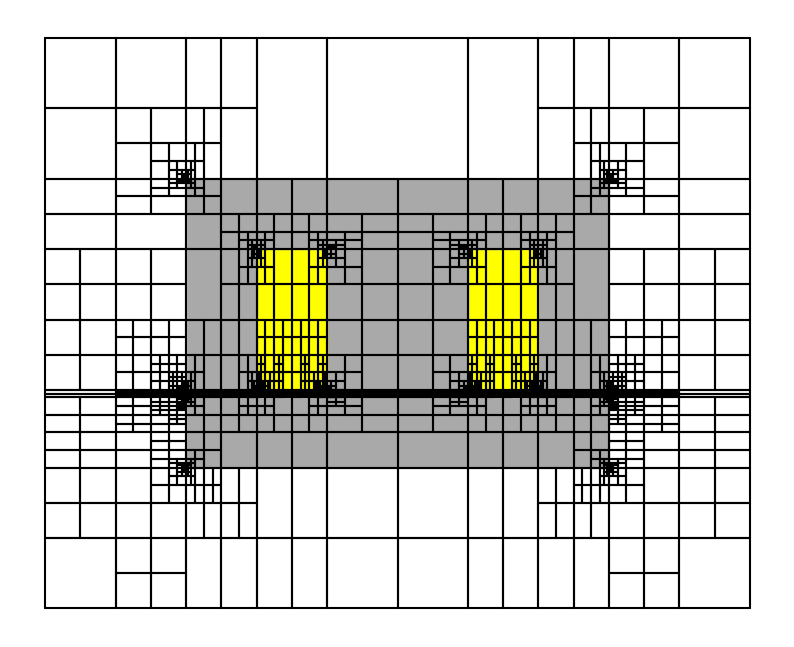

------------------------------------------------------
15
Number of DoFs: 171211
Energy: 0.0008849996678296224 J
Inductance: 1.7699993356592447 mH
------------------------------------------------------
16
Number of DoFs: 483591
Energy: 0.0008849998798107189 J
Inductance: 1.7699997596214379 mH
------------------------------------------------------
0
Number of DoFs: 2793
Energy: 0.0008814047667849434 J
Inductance: 1.7628095335698868 mH


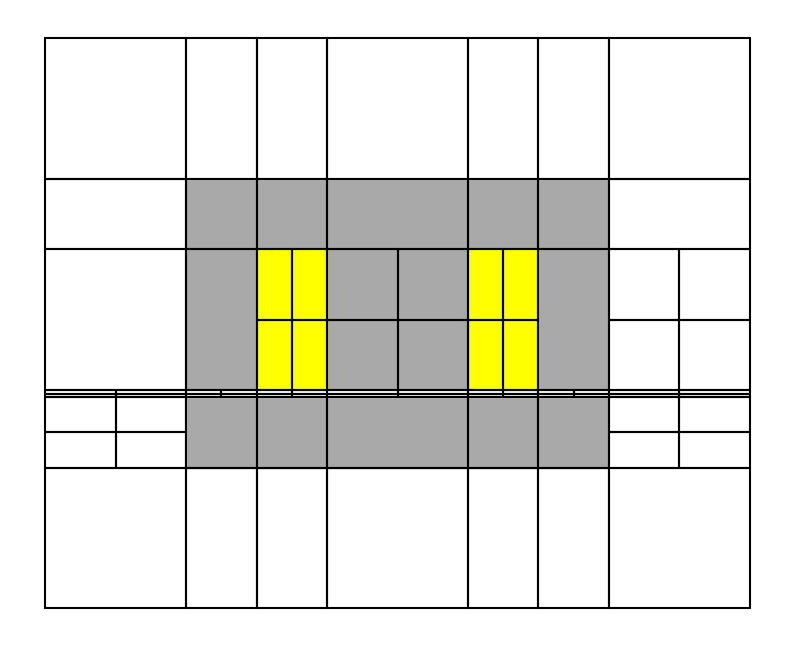

------------------------------------------------------
1
Number of DoFs: 5233
Energy: 0.0008829265773133661 J
Inductance: 1.7658531546267322 mH


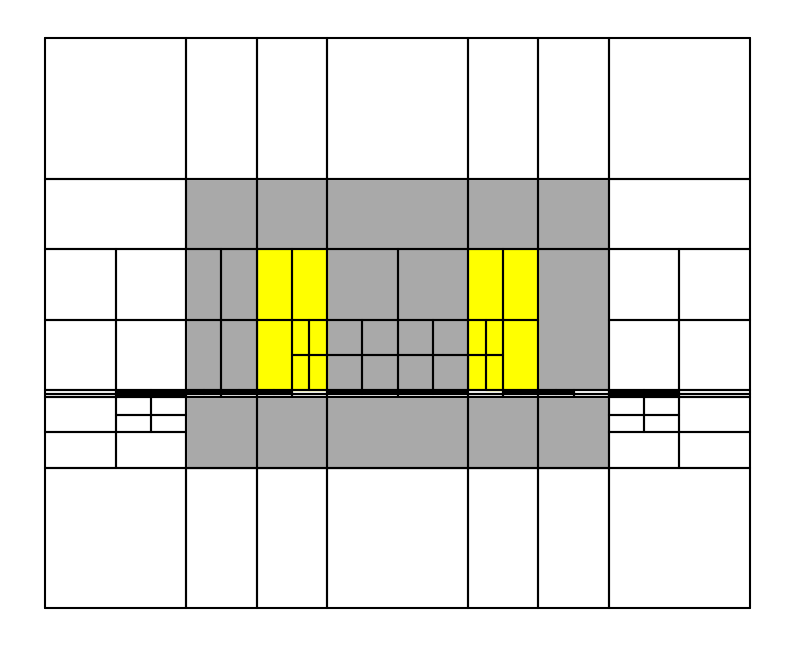

------------------------------------------------------
2
Number of DoFs: 8729
Energy: 0.0008836871158646143 J
Inductance: 1.7673742317292287 mH


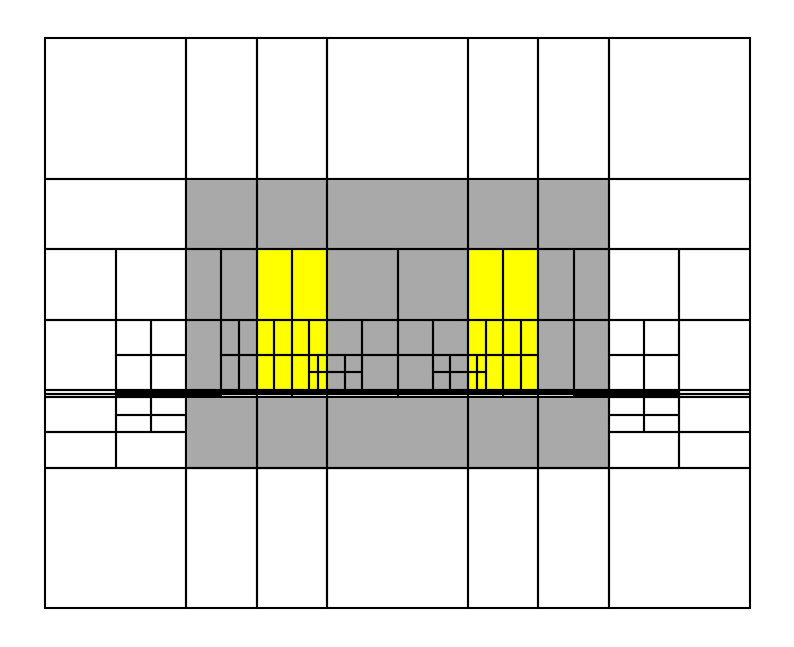

------------------------------------------------------
3
Number of DoFs: 13193
Energy: 0.0008842894011078475 J
Inductance: 1.768578802215695 mH


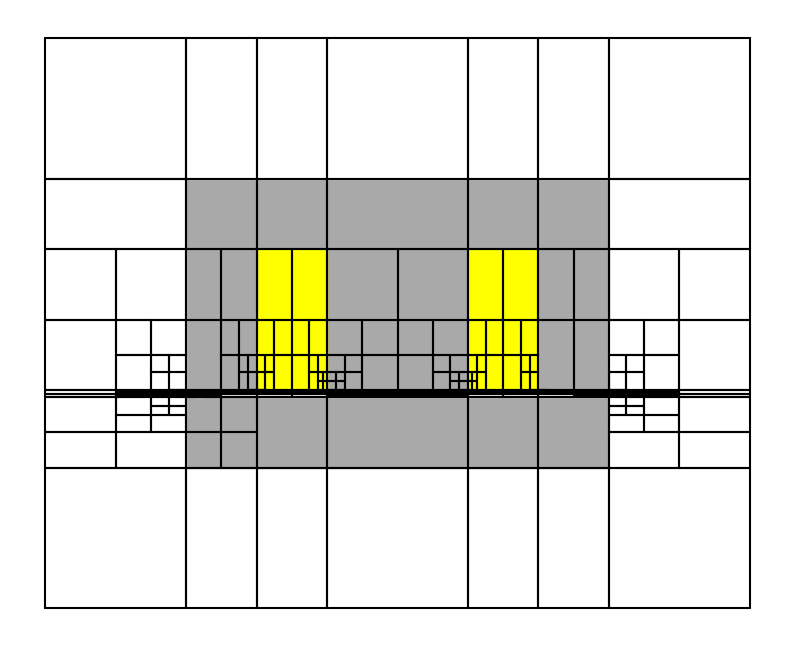

------------------------------------------------------
4
Number of DoFs: 18505
Energy: 0.0008844675070962688 J
Inductance: 1.7689350141925377 mH


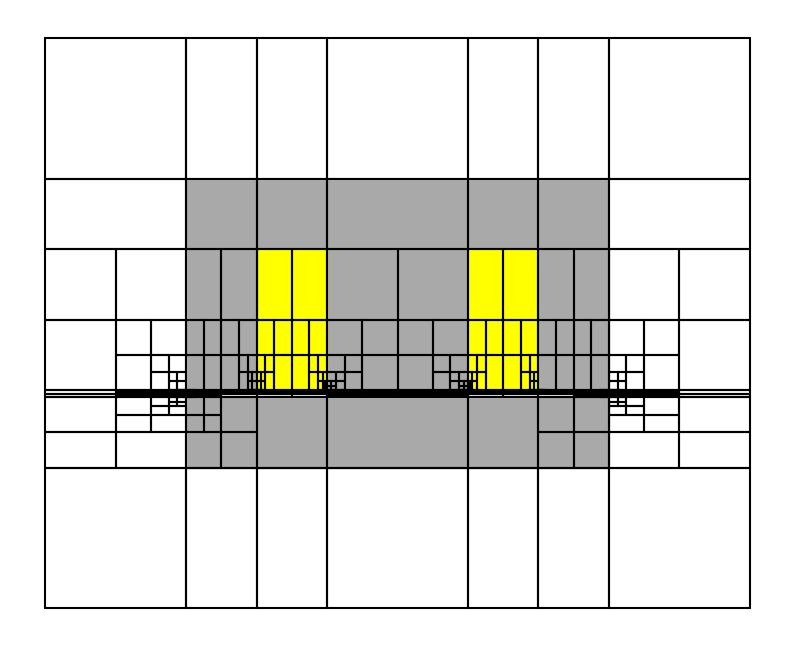

------------------------------------------------------
5
Number of DoFs: 24409
Energy: 0.0008847747575707961 J
Inductance: 1.769549515141592 mH


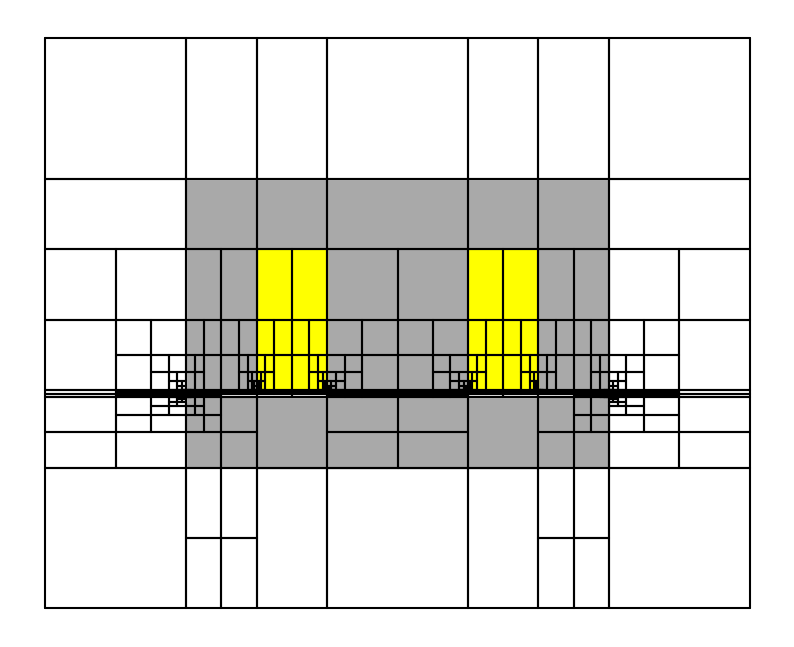

------------------------------------------------------
6
Number of DoFs: 31769
Energy: 0.0008849059997836177 J
Inductance: 1.7698119995672354 mH


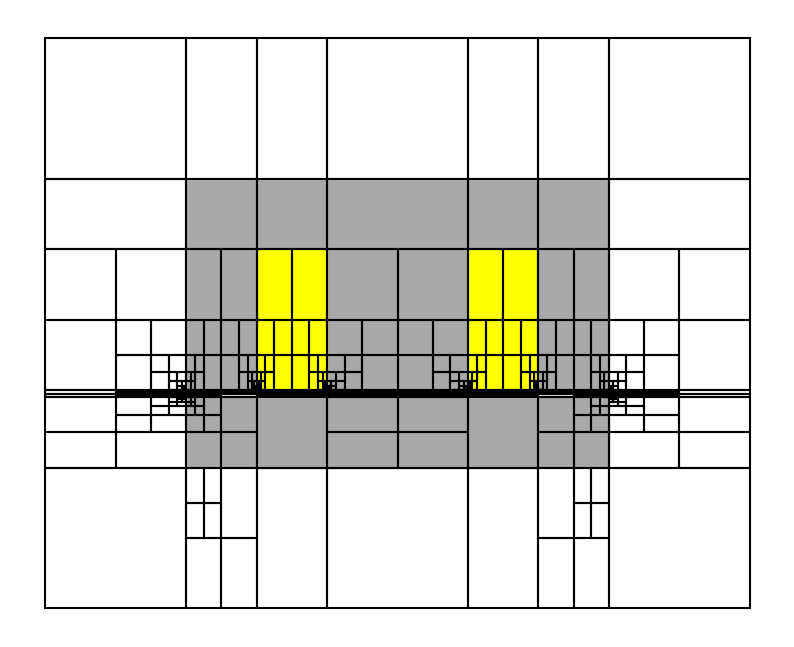

------------------------------------------------------
7
Number of DoFs: 40081
Energy: 0.000884954705161627 J
Inductance: 1.769909410323254 mH


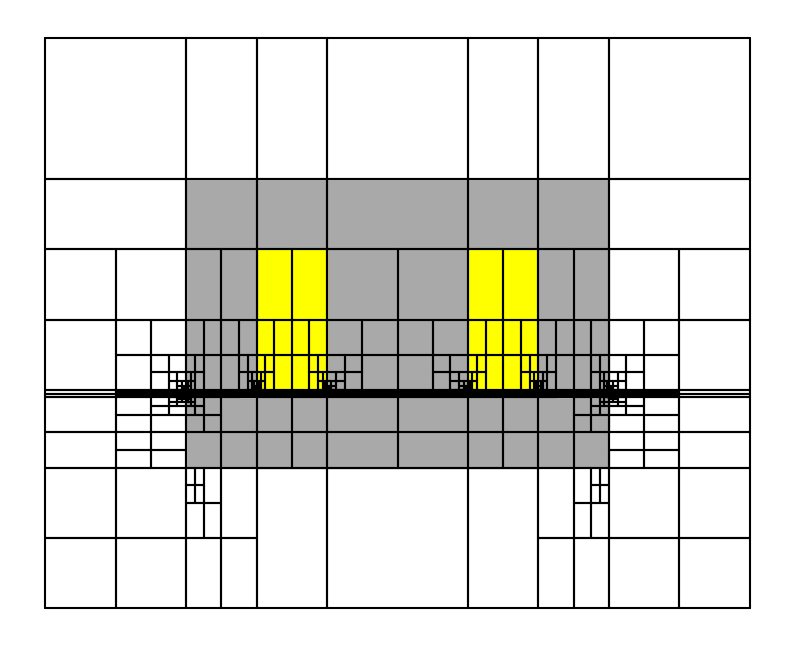

------------------------------------------------------
8
Number of DoFs: 50513
Energy: 0.000884975801665612 J
Inductance: 1.769951603331224 mH


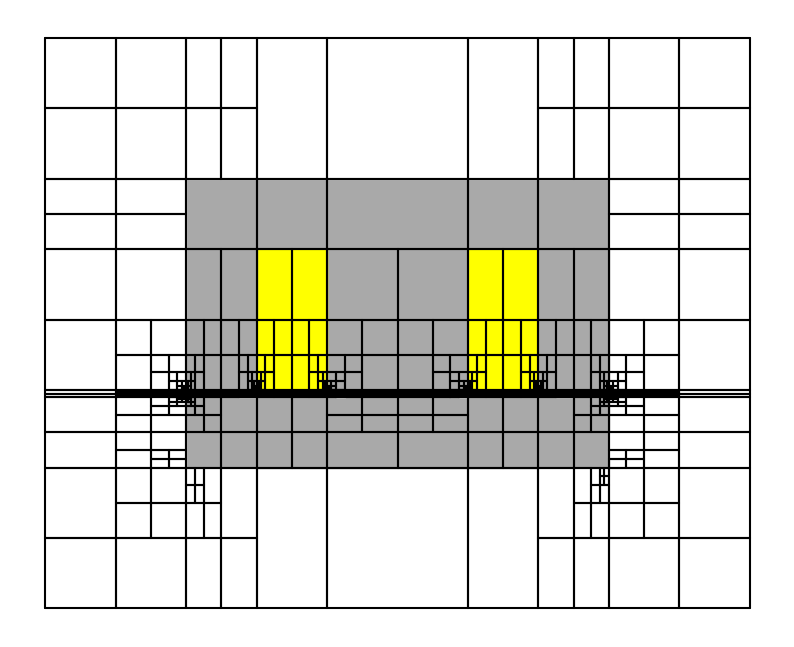

------------------------------------------------------
9
Number of DoFs: 62369
Energy: 0.0008849842233208227 J
Inductance: 1.7699684466416454 mH


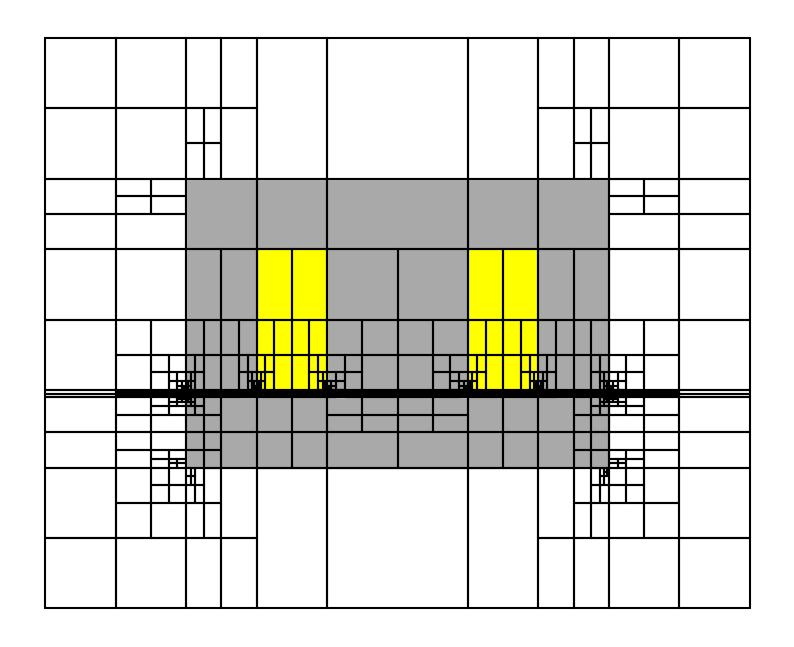

------------------------------------------------------
10
Number of DoFs: 76281
Energy: 0.0008849876631412789 J
Inductance: 1.769975326282558 mH


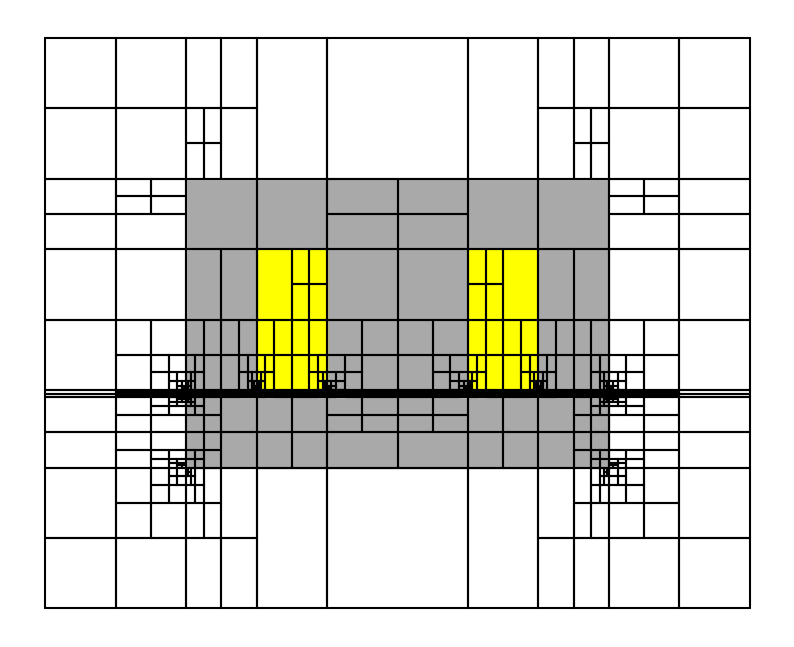

------------------------------------------------------
11
Number of DoFs: 91785
Energy: 0.0008849923728281467 J
Inductance: 1.7699847456562936 mH


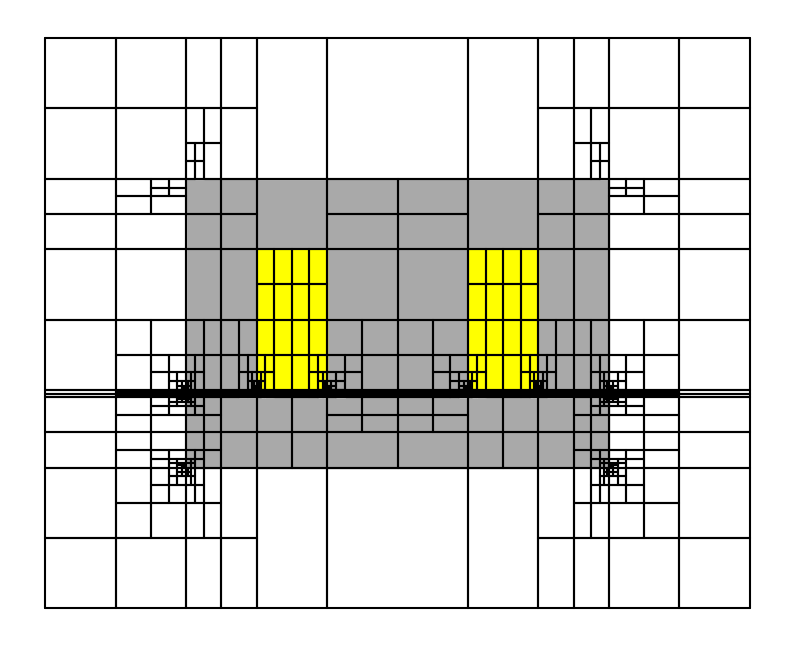

------------------------------------------------------
12
Number of DoFs: 109249
Energy: 0.0008849938970681246 J
Inductance: 1.7699877941362492 mH


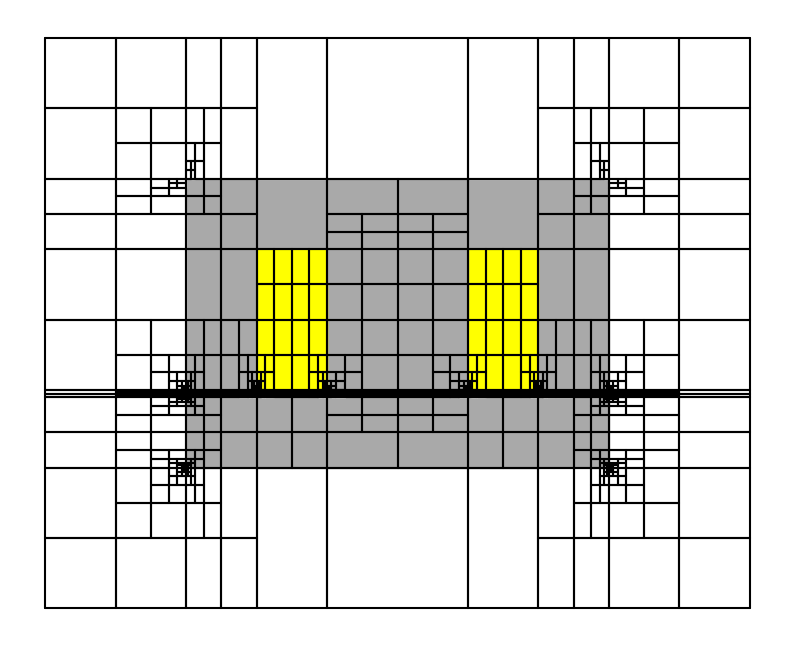

------------------------------------------------------
13
Number of DoFs: 130249
Energy: 0.0008849951672044256 J
Inductance: 1.7699903344088512 mH


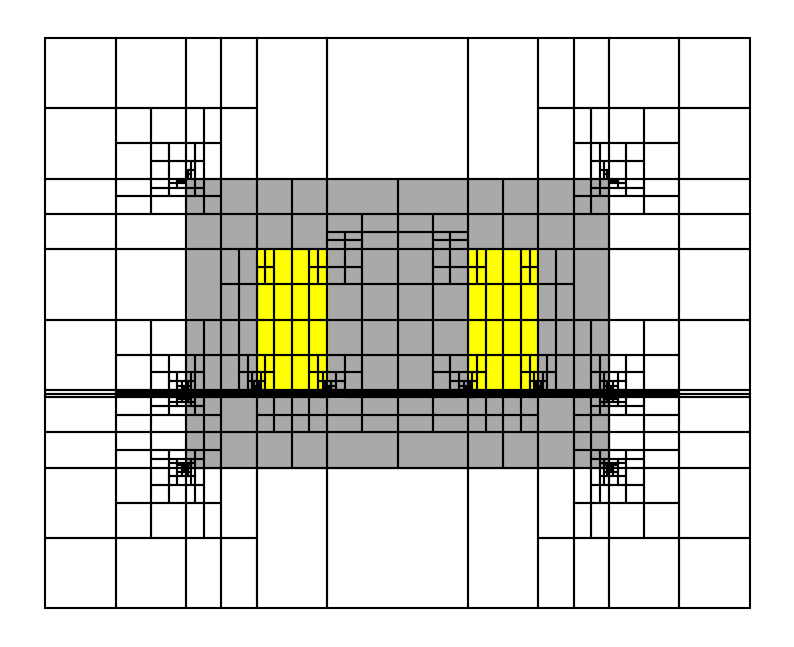

------------------------------------------------------
14
Number of DoFs: 151705
Energy: 0.0008849977206159375 J
Inductance: 1.769995441231875 mH


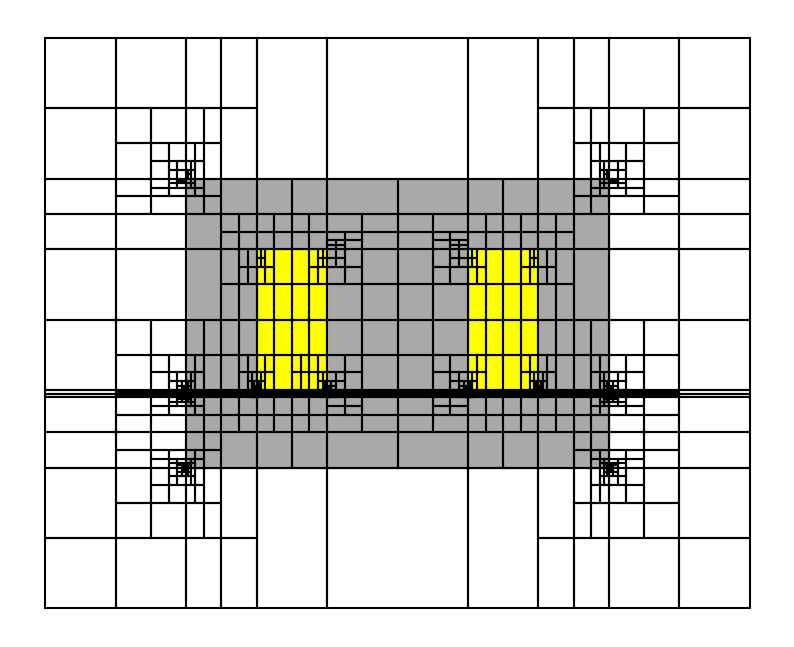

------------------------------------------------------
15
Number of DoFs: 177377
Energy: 0.0008849991181898311 J
Inductance: 1.7699982363796622 mH


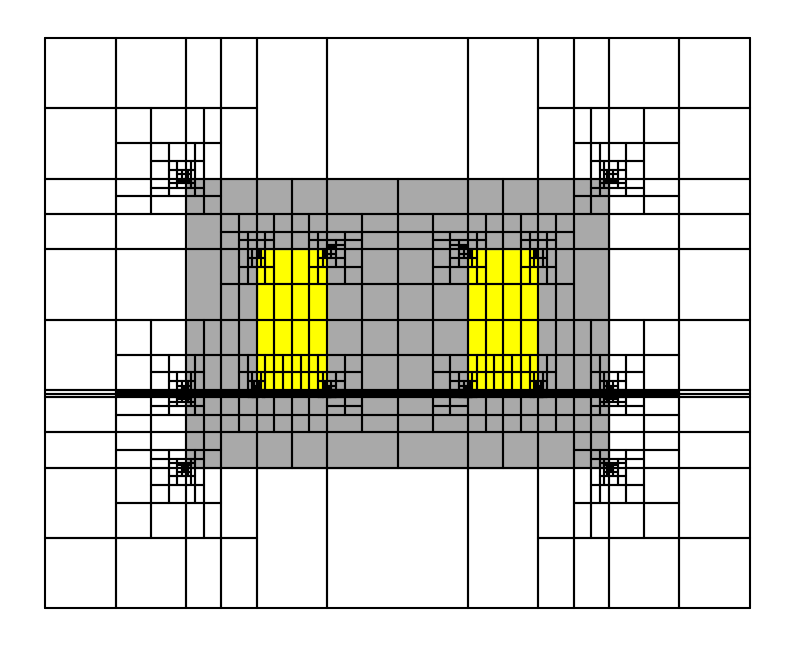

------------------------------------------------------
16
Number of DoFs: 202777
Energy: 0.000884999670812788 J
Inductance: 1.7699993416255762 mH


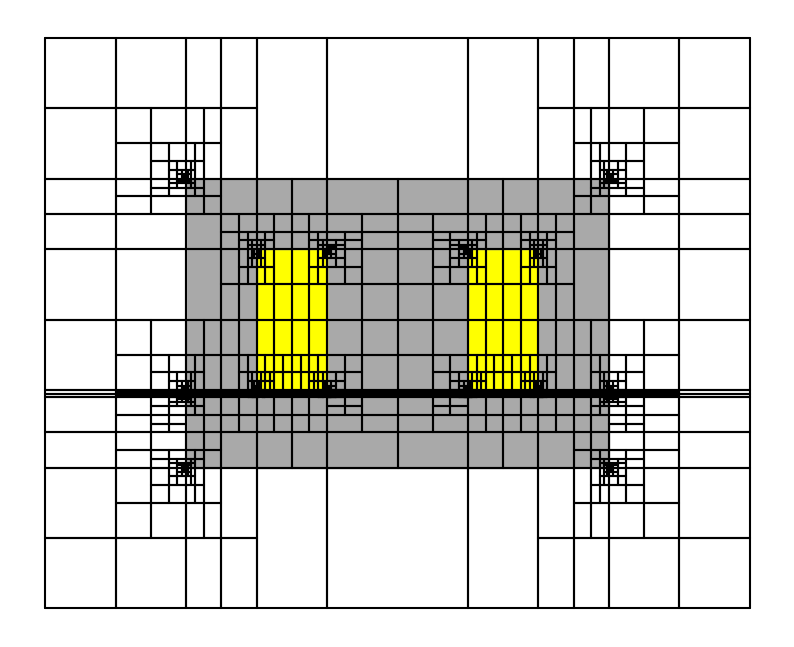

------------------------------------------------------
17
Number of DoFs: 232129
Energy: 0.000884999890188834 J
Inductance: 1.7699997803776681 mH


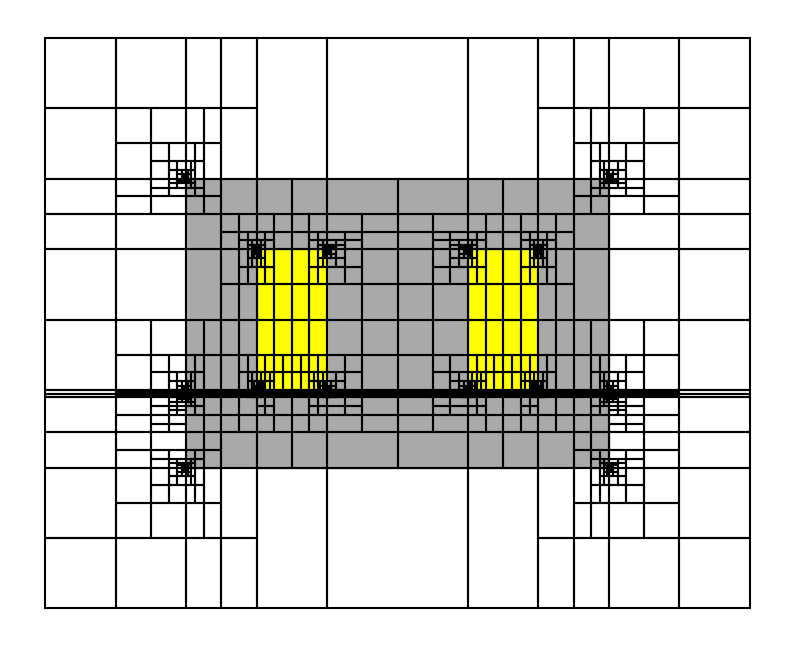

------------------------------------------------------
18
Number of DoFs: 265041
Energy: 0.0008849999773392291 J
Inductance: 1.7699999546784582 mH
------------------------------------------------------
19
Number of DoFs: 709151
Energy: 0.0008850000086714833 J
Inductance: 1.7700000173429666 mH


In [8]:
for deg, maxiter in zip((2,3,4),(15,17,20)):
    M_a=Inductor(deg,deg+1)
    MP_a = assemble.Multipatch(M_a, automatch=True)
    uh_a=[]
    P_a=[]
    err_ind=[]
    Eh_a=np.zeros(maxiter)
    
    time_mesh_a = np.zeros(maxiter)
    time_solve_a = np.zeros(maxiter)
    time_est_a=np.zeros(maxiter)
    nnz_a=np.zeros(maxiter)
    nnzQ_a=np.zeros(maxiter)

    numdofs_a =np.zeros(maxiter)
    err_est=np.zeros(maxiter)

    for i in range(maxiter):
        print('------------------------------------------------------')
        print(i)
        bcs = MP_a.compute_dirichlet_bcs({0:0.})
        Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP_a.assemble_volume('j * v * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
        Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
        
        nnz_a[i] = LS.A.nnz
        nnzQ_a[i] = 100*LS.A.nnz/np.prod(LS.A.shape)
        
        t=time.time()
        uh_a.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        time_solve_a[i]=time.time()-t
        Eh_a[i] = 0.0254 * 0.5 * uh_a[-1]@Ah_a@uh_a[-1]
        #h_a[i]=MP_a.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_=uh_a[-1], nu=nu)*0.0254
        print('Number of DoFs: ' + str(MP_a.numdofs))
        print('Energy: ' + str(Eh_a[i])+' J')
        print('Inductance: ' + str(Eh_a[i]*2000)+' mH')
        numdofs_a[i]=MP_a.numdofs

        if i < maxiter-2 :
            t=time.time()
            err_ind.append(adap.mp_resPois(MP_a, uh_a[-1], f=j, a=nu, M=MaT))
            time_est_a[i]=time.time()-t
            
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_mark(err_ind[-1], 0.9)
            marked_patches = {p:None for p in marked_patches}
            
            t=time.time()
            P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
            time_mesh_a[i]=time.time()-t
            
            MP_a.mesh.draw(figsize=(10,10),color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'},knots=0,bwidth=0.01)
            plt.axis('off');
            plt.axis('scaled');
            plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'_mesh/i'+str(i)+'.png',bbox_inches='tight');
            plt.show()
        elif i == maxiter-2:
            P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
        else:
            pass

    for k in reversed(range(1,len(P_a))):
        P_a[k-1]=P_a[k]@P_a[k-1]

    L2err_a = np.zeros(maxiter)
    H1err_a = np.zeros(maxiter)
    Aherr_a = np.zeros(maxiter)
    Eherr_a = np.zeros(maxiter)
    for i in range(len(uh_a)-1):
        eh = P_a[i]@uh_a[i]-uh_a[-1]
        L2err_a[i] = eh @ Mh_a @ eh
        H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
        Aherr_a[i] = eh @ Ah_a @ eh
        Eherr_a[i]=abs(Eh_a[-1]-Eh_a[i])

    L2err_a = sqrt(L2err_a)
    H1err_a = sqrt(H1err_a)
    Aherr_a = sqrt(Aherr_a)
    
    Ih_a = 2000 * Eh_a

    np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a, nnz_a, nnzQ_a ,H1err_a,L2err_a,Aherr_a,Eh_a,Ih_a,time_mesh_a,time_est_a,time_solve_a]])

In [12]:
M = Inductor(2,3)
MP = assemble.Multipatch(M, automatch=True)
kvs, geos = MP.mesh.kvs, MP.mesh.geos

Basis setup took 0.013923168182373047 seconds


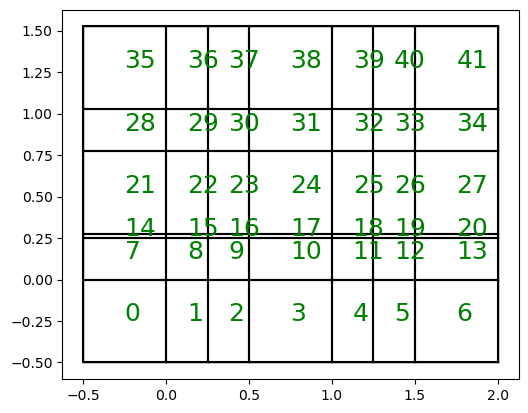

In [13]:
MP.mesh.draw(patch_idx=True)

In [48]:
nu['C1']/nu['Fe']

2500.0000000000005

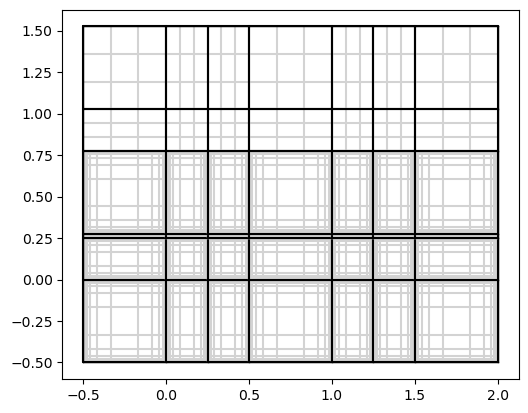

In [41]:
MP_geo.mesh.draw(knots=True)

In [8]:
for i in range(3):
    MP.h_refine();
    adap.PoissonEstimator(MP, uh = np.zeros(MP.numdofs))

Refinement took 0.3822510242462158 seconds for 42 patches.
Basis setup took 0.07076001167297363 seconds
Residual contributions took 1.3554270267486572 seconds.
Refinement took 4.167315483093262 seconds for 168 patches.
Basis setup took 0.2773246765136719 seconds
Residual contributions took 3.829657554626465 seconds.
Refinement took 60.90325403213501 seconds for 672 patches.
Basis setup took 1.7740912437438965 seconds
Residual contributions took 15.303276300430298 seconds.


In [36]:
adap.PoissonEstimator(MP, uh = np.zeros(MP.numdofs))

Residual contributions took 0.9817352294921875 seconds.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
len(MP.N_ofs)

43

In [85]:
MP.N_ofs

array([   0,   25,   50,   75,  100,  125,  150,  175,  200,  225,  250,  275,  300,  325,  350,  375,  400,  425,  450,  475,  500,  525,  550,  575,  600,  625,  650,  675,  700,  725,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975, 1000, 1025, 1050])

In [68]:
uh_loc = np.zeros(MP.numloc_dofs)

In [80]:
p=7
uh_loc[MP.N_ofs[p]:MP.N_ofs[p+1]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [92]:
R = np.array([assemble.assemble('(f + div(grad(uh))) * v * dx', kvs=kv0 , geo=geo , f=lambda x,y: 1.,uh=geometry.BSplineFunc(kv, uh_loc[MP.N_ofs[p]:MP.N_ofs[p+1]])).ravel() for p, (kv0, kv, geo) in enumerate(zip(kvs0,kvs,geos))])

In [100]:
h**2 * R.sum(axis=1)

array([1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 3.48090e-04, 4.38368e-05, 4.38368e-05, 3.48090e-04, 4.38368e-05, 4.38368e-05, 3.48090e-04, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02])

In [98]:
R.sum(axis=1)

array([0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0125 , 0.00625, 0.00625, 0.0125 , 0.00625, 0.00625, 0.0125 , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   ])

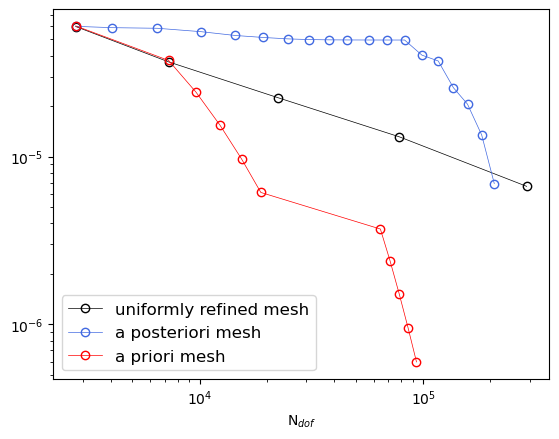

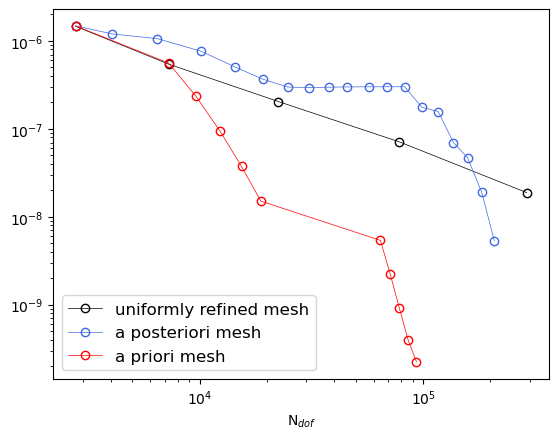

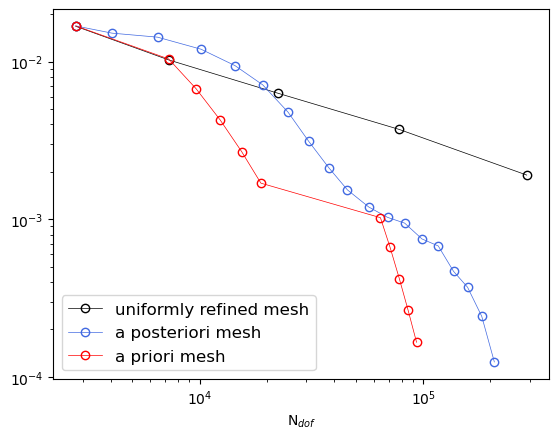

In [34]:
deg=4
[numdofs, nnz, nnzQ, H1err,L2err,Aherr,Eh,time_mesh,time_solve]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a, nnz_a, nnzQ_a ,H1err_a,L2err_a,Aherr_a,Eh_a,time_mesh_a,time_est_a,time_solve_a]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo, nnz_geo, nnzQ_geo , H1err_geo, L2err_geo, Aherr_geo, Eh_geo, time_mesh_geo, time_solve_geo]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'geo.txt')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], H1err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

#draw_loglog_slope(fig,ax,(1e5,1.9*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(5*1e4,9*1e-3),1,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], L2err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

#draw_loglog_slope(fig,ax,(1e5,2.5*1e-5),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(5*1e4,2.5*1e-6),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#fig, ax = plt.subplots()
# plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_geo[:-1], Aherr_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], Aherr_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

plt.show()



In [10]:
H1err_a

array([0.00014, 0.00013, 0.00011, 0.00011, 0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.     ])

In [11]:
L2err_a

array([8.16256e-06, 6.96800e-06, 3.68782e-06, 2.46796e-06, 1.95109e-06, 1.85318e-06, 1.85839e-06, 1.86715e-06, 1.87316e-06, 0.00000e+00])

In [20]:
Eerr

array([6.99408e-05, 3.97206e-05, 1.91405e-05, 7.74537e-06, 2.38368e-06, 1.22320e-07, 0.00000e+00])

In [16]:
Eerr

array([6.99408e-05, 3.97206e-05, 1.91405e-05, 7.74537e-06, 2.38368e-06, 1.22320e-07, 0.00000e+00])

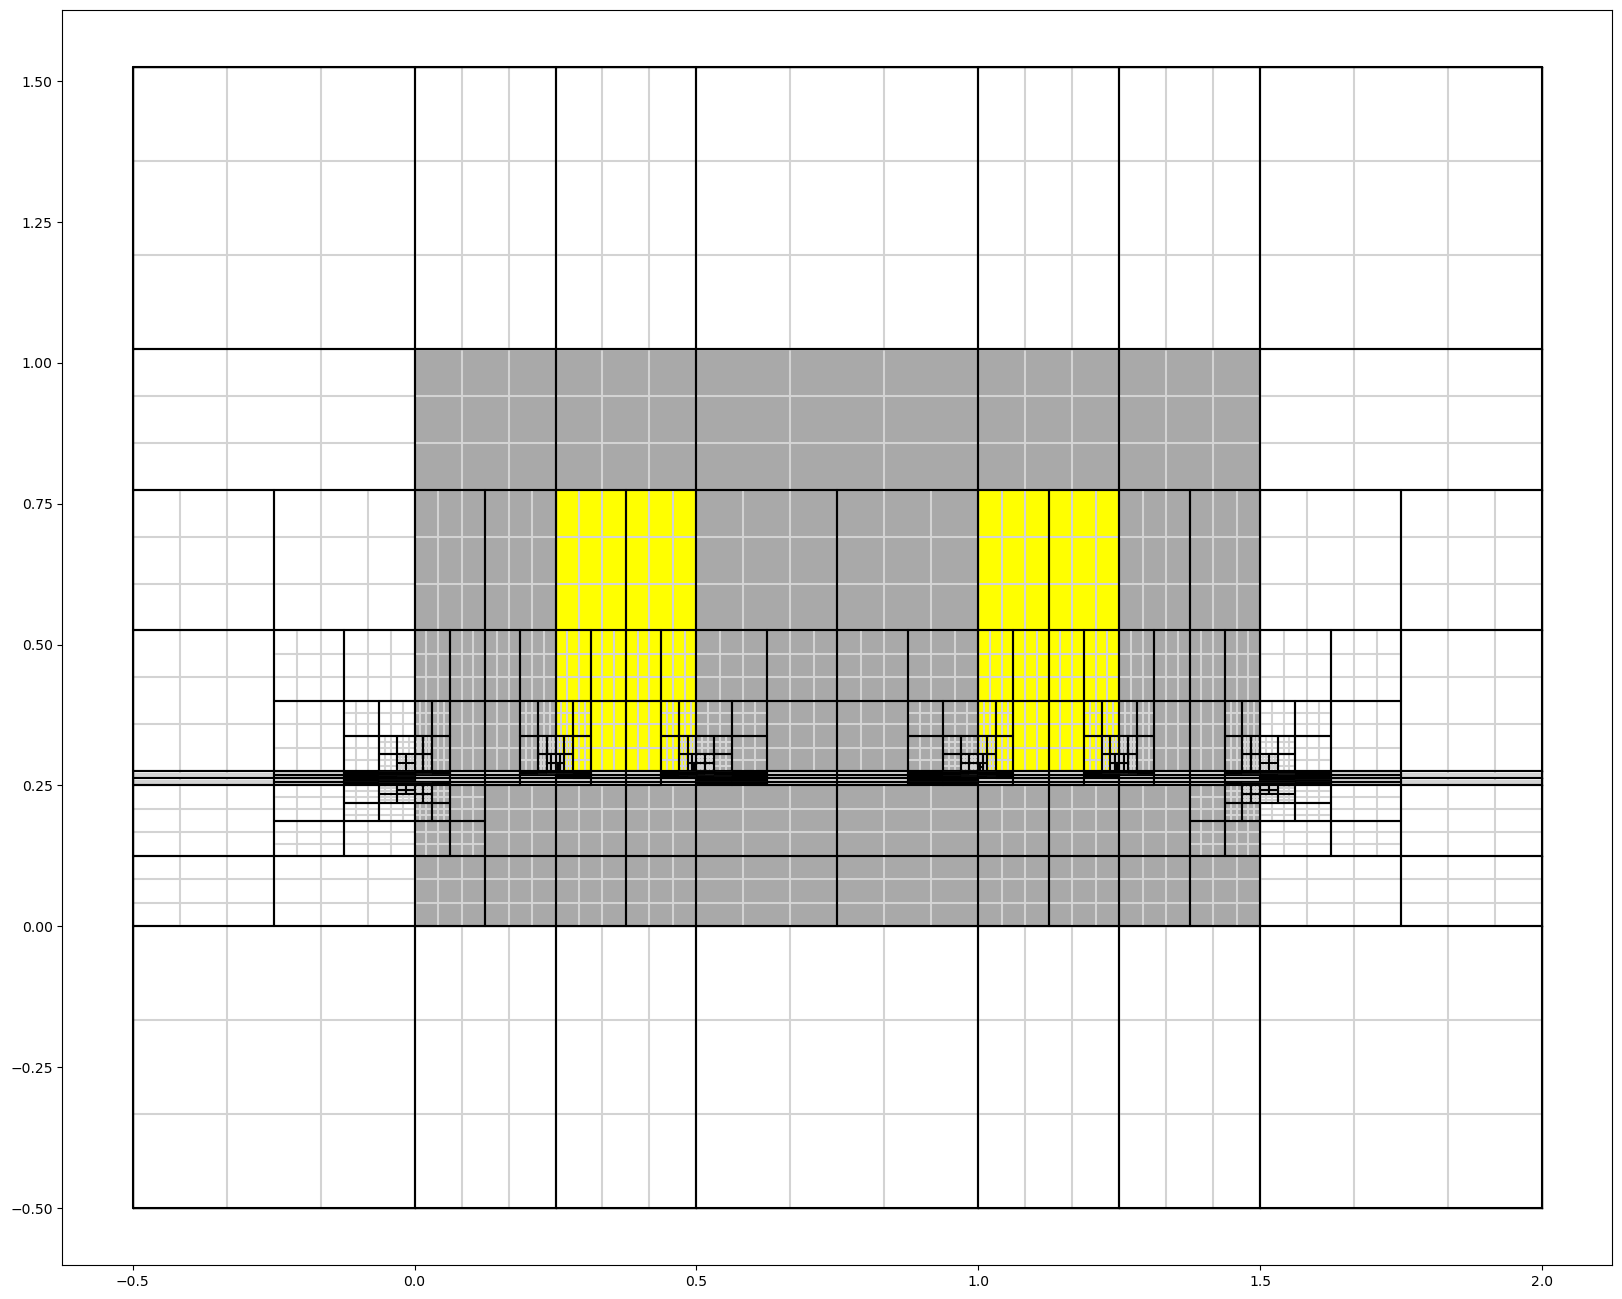

In [34]:
MP_a.mesh.draw(knots=True, color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'}, figsize=(20,20))

In [ ]:
M.draw(knots=True, patch_idx=False, figsize=(10,10), color={'Air':'white', 'Fe':'darkgray', 'C1':'yellow', 'C2':'yellow'})

In [12]:
MP_a.integrate

{'Air': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}}

In [24]:
bd1=geometry.line_segment((1,0),(2,0))
bd3=geometry.line_segment((0,1),(0,2))
bd4=geometry.line_segment((0,1),(1,0))

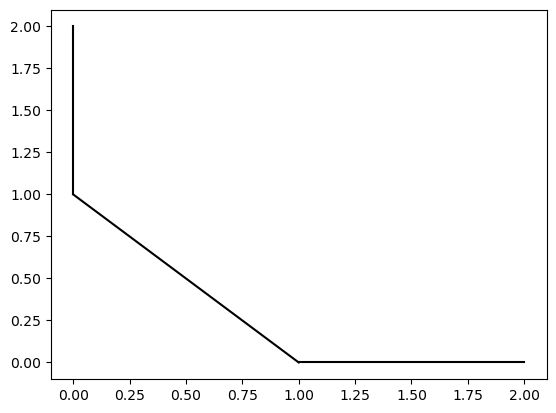

In [26]:
vis.plot_geo(bd3)
vis.plot_geo(bd3)
vis.plot_geo(bd4)

In [36]:
bd2=geometry.BSplineFunc(bspline.KnotVector(np.array([0,0,0,1,1,1]),2),coeffs=np.array([[2.,0.],
                                                                                        [2.,2.],
                                                                                        [0.,2.]]))

In [53]:
bd1.kvs

(KnotVector(array([0., 0., 1., 1.]), 1),)

In [59]:
geo=geometry.quarter_annulus()

In [61]:
geo.coeffs_weights()

(array([[[1., 0.],
         [2., 0.]],
 
        [[1., 1.],
         [2., 2.]],
 
        [[0., 1.],
         [0., 2.]]]),
 array([[1.     , 1.     ],
        [0.70711, 0.70711],
        [1.     , 1.     ]]))

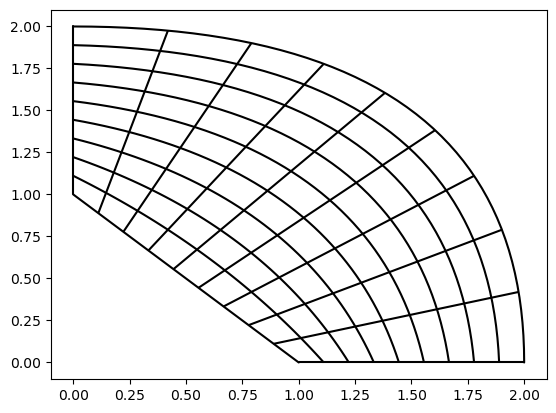

In [3]:
vis.plot_geo(geometry.bspline_annuseg())